# Pipeline for Analyzing Asters

Today we will extract ATP gradients from an aster dataset. Executing the next few cells will import all the relevant data.

## Imports

In [1]:
# # Packages to locally download data into the notebook:
# import requests
# import zipfile
import glob

#Numpy
import numpy as np

#For image plotting
import skimage.io

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import regionprops
import cv2

#for image registration
from skimage.registration import phase_cross_correlation
import os

# For loading bars
from tqdm.notebook import tqdm as tqdm
import aster_packages

#Movie
import celluloid as cell
import matplotlib.animation as animation

### plotting

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 8
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
mpl.rc("figure", dpi=200)

## Initializing Images

Function to convert a list of string file paths into an array of images

In [3]:
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list = list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))

    return np.array(im_list)

### Specifying files

Specify the directory path to navigate to the data. Additionally, Specify which position you are interested in analyzing as well as the channels

In [4]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/aster'
file_folder = '2022-06-28_NCD_ATeam_UMT/2022-06-28_NCD_ATeam_UMT_R4_1'

# #Choose the position(s)/aster(s) of interest:
pos_list = ['Pos1']

#Choose the channels of interest (this is almost always going to be Cherry and iATP)
channel_list = ['GFP', 'CFP', 'Cherry']

#included frames
included_frames = '*2022*.tif'

### Creating image arrays

Combines the specified path information with the function to read files and outputs an array of all the data

In [5]:
# Import images
for pos in pos_list:
    for channel in channel_list:

        #creates an empty list with the naming convention
        exec('im_files' + channel + pos + '= []')
        im_files = eval('im_files' + channel + pos)
        
        #appends all the file names
        im_files.append(
            np.sort(
                glob.glob(file_path + '/' + file_folder + '/' + pos + '/' + channel + '/' +
                          included_frames)))

        #Reads the files as images
        exec('im_array' + channel + pos + ' = file_to_image(im_files[0])')
        print('im_array' + channel + pos)

im_arrayGFPPos1
im_arrayCFPPos1
im_arrayCherryPos1


### Reading camera off images

Include dark, camera off images for camera background subtraction

In [6]:
#Choose the dark ims file name(located in folder 'Asters'):
file_path = '../../data/aster/2022-06-15_Ncd_ATeam_Victor+Cathy/2022-06-13_Ncd_ATeam_Victor+cathy_darkims'

im_MT_dark = skimage.io.imread(
    file_path + '/' + '*C1*.ome.tif'
).astype(np.int16)

im_GFP_dark = skimage.io.imread(
    file_path + '/' + '*C2*.ome.tif'
).astype(np.int16)

im_CFP_dark = skimage.io.imread(
    file_path + '/' + '*C3*.ome.tif'
).astype(np.int16)

im_Cherry_dark = skimage.io.imread(
    file_path + '/' + '*C4*.ome.tif'
).astype(np.int16)

### Autofluorescence

In [7]:
#Motor Autofluor images:

file_path = '../../data/atp_cal/2022-06-29_ATeam_Cal/2022-06-29_ATeam_Cal_2/images'
included_Mot = '*C1*.tif'
Mot_files = np.sort(glob.glob(file_path+'/'+included_Mot))
im_Cherry_autofluor_array = aster_packages.file_to_image(Mot_files)

im_Cherry_autofluor = np.average(im_Cherry_autofluor_array, axis=0)

### Parameter Settings

List of relevant parameters to specify image sizes, um to pixel conversion, etc

In [8]:
#Length Calibration (microns to pixels)
um_per_pixel = 0.59

#Image dims
w_px, h_px = 1920, 1200  #pixels
w_um, h_um = w_px * um_per_pixel, h_px * um_per_pixel  # microns

#min area thresh (IN PIXELS)
area_thresh = 1000

#Fontsize
f_small, f_big = 13, 15

#For binning
winsize = 200
thickness = 20
scale = 5

#Total number of imported images per channel
total_frames = len(im_arrayGFPPos1) - 1

Plot the imported data

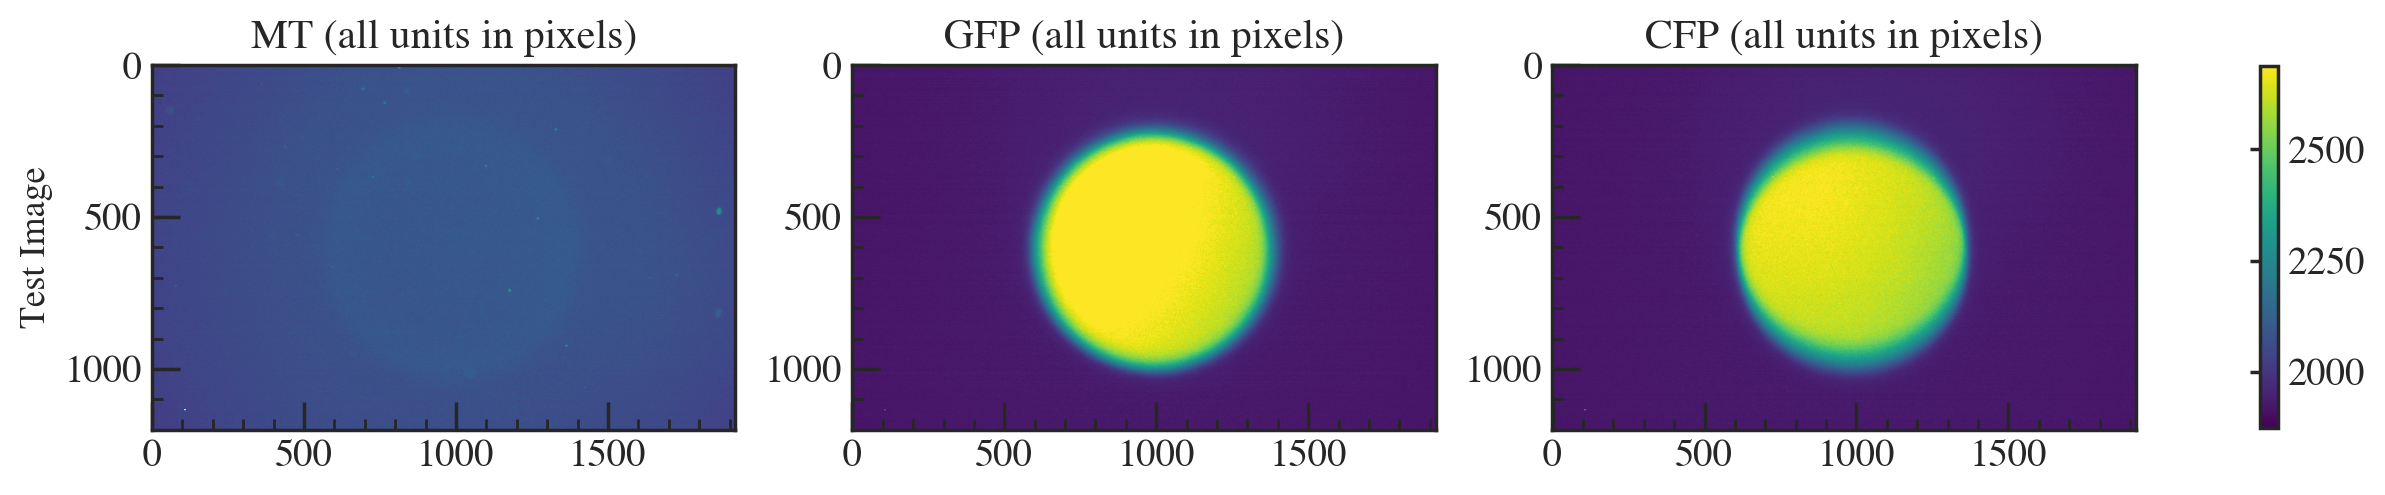

In [9]:
frame = 3
im_CFP = im_arrayCFPPos1[frame]
im_GFP = im_arrayGFPPos1[frame]
im_Cherry = im_arrayCherryPos1[frame]
# im_Cherry = im_Cherry_dark

#define colorbar max and min
colorbar_max = np.percentile(im_CFP, 99)
colorbar_min = np.percentile(im_CFP, 0)

#define plot
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer)

#define each subplot
ax[0].imshow(im_Cherry, vmin = colorbar_min, vmax = colorbar_max)
ax[0].set_title('MT (all units in pixels)', fontsize=f_big)
ax[0].set_ylabel('Test Image', fontsize=f_small)

ax[1].imshow(im_GFP, vmin = colorbar_min, vmax = colorbar_max)
ax[1].set_title('GFP (all units in pixels)', fontsize=f_big)

ax[2].imshow(im_CFP, vmin = colorbar_min, vmax = colorbar_max)
ax[2].set_title('CFP (all units in pixels)', fontsize=f_big)

fig.colorbar(cb_setting, ax=ax.ravel().tolist(), shrink = 0.3)

## Image corrections

### Subtract the camera background image

Subtract the dark camera image from each image and the autofluorescent image. If there are any negative values, set them to zero

In [10]:
# subtracting bg image
im_arrayGFPPos1_bs = im_arrayGFPPos1 - im_GFP_dark
im_arrayCFPPos1_bs = im_arrayCFPPos1 - im_CFP_dark
im_arrayCherryPos1_bs = im_arrayCherryPos1 - im_Cherry_dark
im_Cherry_autofluor_bs = im_Cherry_autofluor - im_Cherry_dark

# Set negative values to zero
bool_array = (im_arrayGFPPos1_bs > 0)
im_arrayGFPPos1_bs_nonneg = im_arrayGFPPos1_bs * bool_array

bool_array = (im_arrayCFPPos1_bs > 0)
im_arrayCFPPos1_bs_nonneg = im_arrayCFPPos1_bs * bool_array

bool_array = (im_arrayCherryPos1_bs > 0)
im_arrayCherryPos1_bs_nonneg = im_arrayCherryPos1_bs * bool_array

bool_array = (im_Cherry_autofluor_bs > 0)
im_Cherry_autofluor_bs_nonneg = im_Cherry_autofluor_bs * bool_array

### Normalize Images

This corrects for uneven illumination. The light gradient that comes from instrumentation "should" be the same for each frame. Here, take the first frame of the image sequence and create a normalization matrix. This matrix is created by dividing each pixel in the image by the maximum pixel value, so that when you multiply the original image by the normalization matrix, the first frame will be a homogeneous image with the highest pixel value. All future frames can be multiplied by the matrix to remove the systematic light gradient

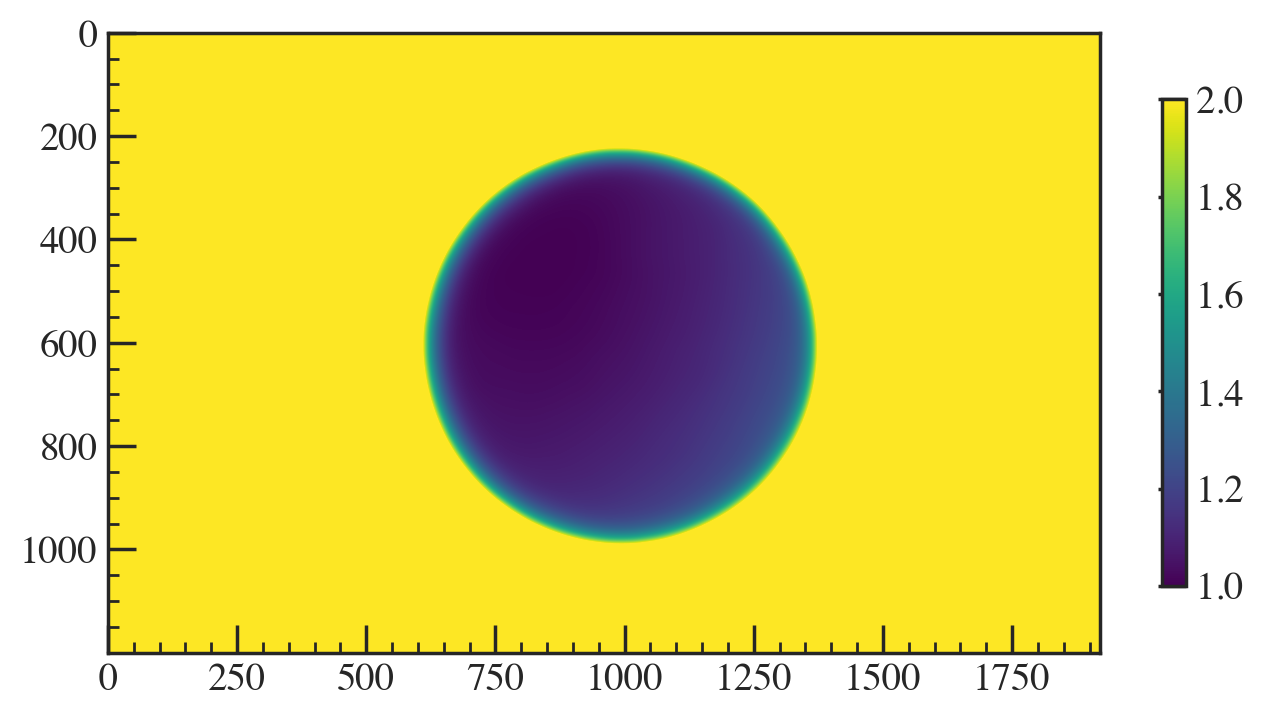

In [11]:
#Set the first imaga as the sacrificial normalization image
GFP_zero = im_arrayGFPPos1[0]
CFP_zero = im_arrayCFPPos1[0]
Cherry_zero = im_arrayCherryPos1[0]

# Create the normalization matrix
GFP_norm_mat = aster_packages.norm_mat_fn_iATP(GFP_zero, im_GFP_dark)
CFP_norm_mat = aster_packages.norm_mat_fn_iATP(CFP_zero, im_CFP_dark)
Cherry_norm_mat = aster_packages.norm_mat_fn_iATP(Cherry_zero, im_Cherry_dark)

#Plot the normalization matrix
plt.imshow(GFP_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)

Multiply the image stacks by a binary image and then the normalization matrix:

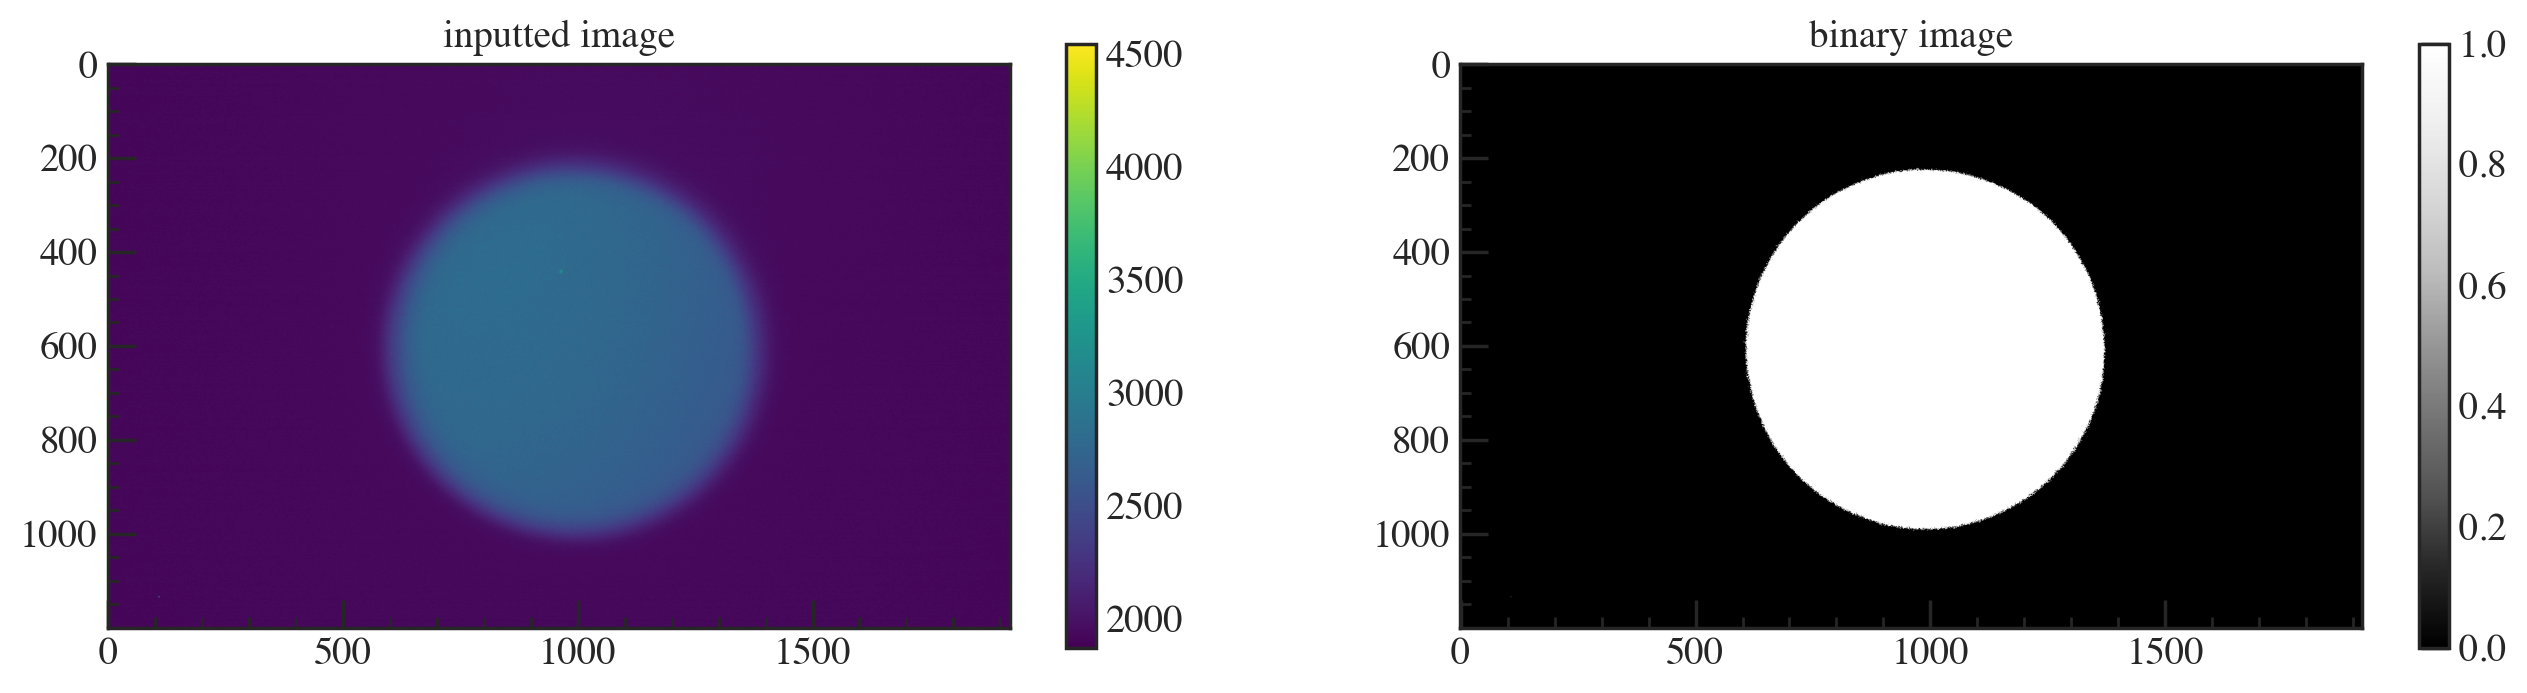

In [12]:
#Ensure all pixels are floats
im_arrayGFPPos1_bs_nonneg = im_arrayGFPPos1_bs_nonneg.astype(float)
im_arrayCFPPos1_bs_nonneg = im_arrayCFPPos1_bs_nonneg.astype(float)
im_arrayCherryPos1_bs_nonneg = im_arrayCherryPos1_bs_nonneg.astype(float)

#Multiply by a binary mask that only retains non-zero values for inside the roi
im_binary = aster_packages.binary_im_generator(GFP_zero)
GFP_norm_mask = GFP_norm_mat * im_binary
CFP_norm_mask = CFP_norm_mat * im_binary

# Multiply the images by the normalization matrix
im_arrayGFPPos1_bs_norm = GFP_norm_mask * im_arrayGFPPos1_bs_nonneg
im_arrayCFPPos1_bs_norm = CFP_norm_mask * im_arrayCFPPos1_bs_nonneg
im_arrayCherryPos1_bs_norm = Cherry_norm_mat*im_arrayCherryPos1_bs_nonneg


### Photobleaching correction

0it [00:00, ?it/s]

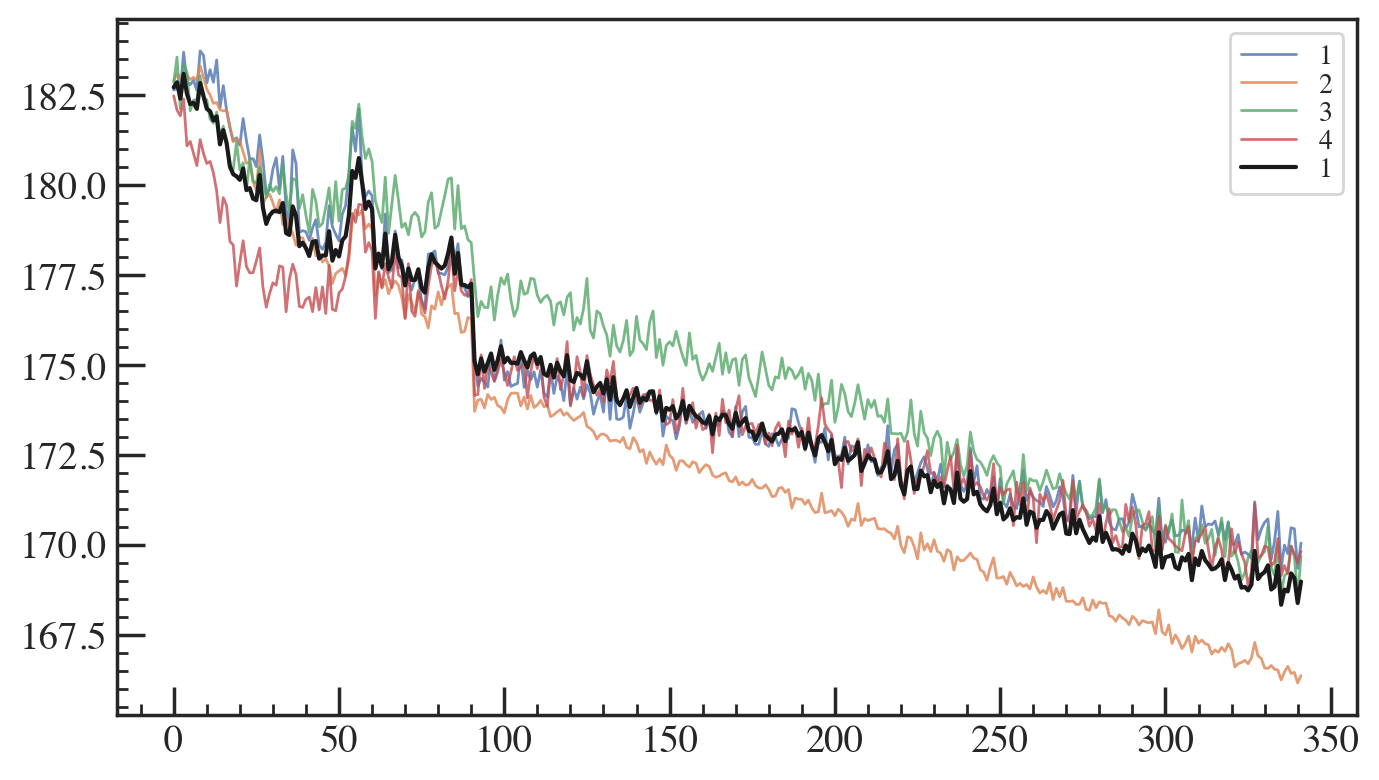

In [13]:
avg1 = np.zeros(len(im_arrayCherryPos1_bs_norm))
avg2 = np.zeros(len(im_arrayCherryPos1_bs_norm))
avg3 = np.zeros(len(im_arrayCherryPos1_bs_norm))
avg4 = np.zeros(len(im_arrayCherryPos1_bs_norm))
edgeCherryavg = np.zeros(len(im_arrayCherryPos1_bs_norm))

for i, im in tqdm(enumerate(im_arrayCherryPos1_bs_norm)):
    avg1[i] += np.average(im[:, :300])
    avg2[i] += np.average(im[:, -300:])
    avg3[i] += np.average(im[:150, :])
    avg4[i] += np.average(im[-150:, :])
    edgeCherryavg[i] += np.average([avg1[i], avg2[i], avg3[i], avg4[i]])

plt.plot(np.arange(len(edgeCherryavg)), avg1, label = '1', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgeCherryavg)), avg2, label = '2', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgeCherryavg)), avg3, label = '3', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgeCherryavg)), avg4, label = '4', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgeCherryavg)), edgeCherryavg, label = '1', color = 'k', linewidth=1.5)
plt.legend();


In [14]:
bleach_correction = edgeCherryavg[0]/edgeCherryavg
bleach_correction_ims = np.ones((len(bleach_correction), h_px, w_px))
for i, im in tqdm(enumerate(bleach_correction_ims)):
    bleach_correction_ims[i] *= im*bleach_correction[i] 
im_arrayCherryPos1_bs_norm_bleach = im_arrayCherryPos1_bs_norm*bleach_correction_ims

0it [00:00, ?it/s]

0it [00:00, ?it/s]

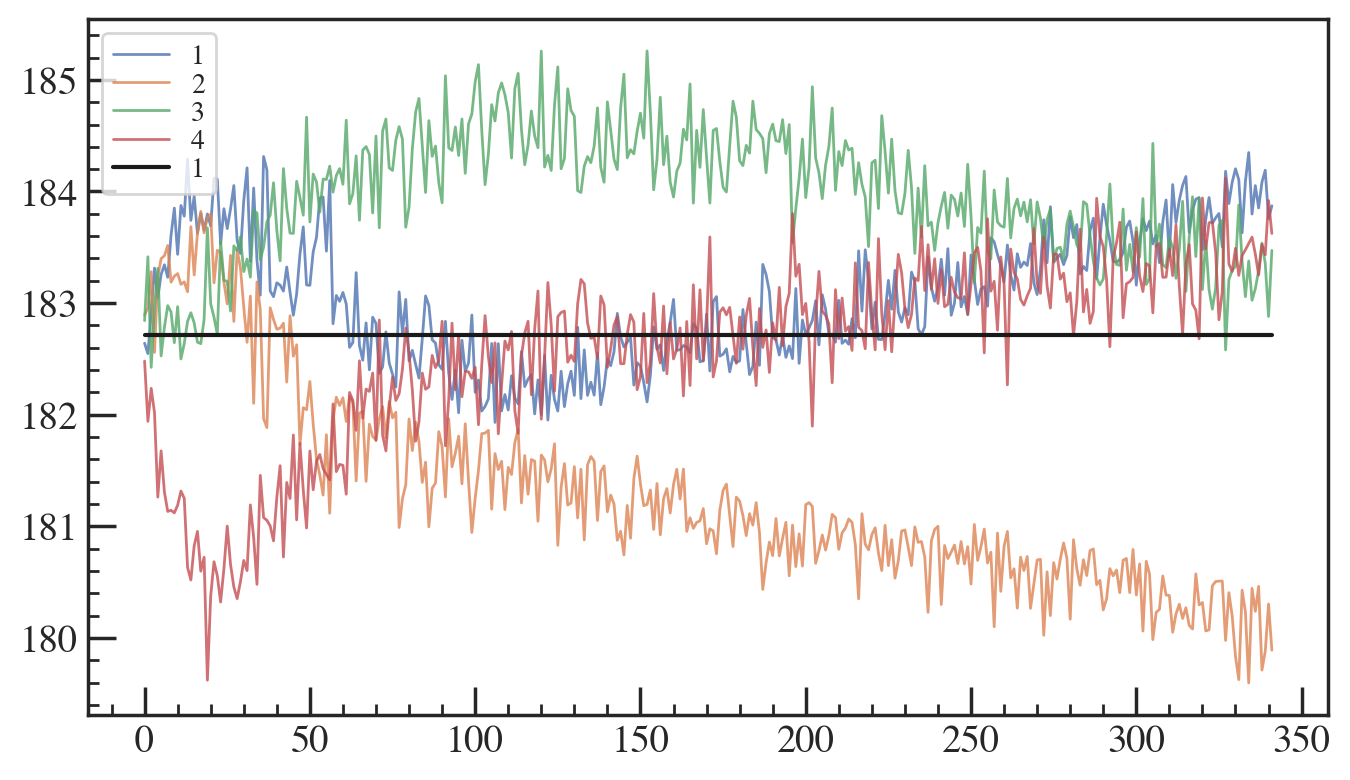

In [15]:
avg5 = np.zeros(len(im_arrayCherryPos1_bs_norm))
avg6 = np.zeros(len(im_arrayCherryPos1_bs_norm))
avg7 = np.zeros(len(im_arrayCherryPos1_bs_norm))
avg8 = np.zeros(len(im_arrayCherryPos1_bs_norm))
edgeCherryavg1 = np.zeros(len(im_arrayCherryPos1_bs_norm))

for i, im in tqdm(enumerate(im_arrayCherryPos1_bs_norm_bleach)):
    avg5[i] += np.average(im[:, :300])
    avg6[i] += np.average(im[:, -300:])
    avg7[i] += np.average(im[:150, :])
    avg8[i] += np.average(im[-150:, :])
    edgeCherryavg1[i] += np.average([avg5[i], avg6[i], avg7[i], avg8[i]])


plt.plot(np.arange(len(edgeCherryavg)), avg5, label = '1', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgeCherryavg)), avg6, label = '2', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgeCherryavg)), avg7, label = '3', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgeCherryavg)), avg8, label = '4', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgeCherryavg)), edgeCherryavg1, label = '1', color = 'k', linewidth=1.5)
plt.legend();


### Establish protein per fluor

In [16]:
protein_per_fluo = 1.24/np.average(im_arrayCherryPos1_bs_norm_bleach[0])/1.24 #µM

### Center (w/ Gaussian blur)

Define a crop window

In [17]:
c_ymin, c_ymax, c_xmin, c_xmax = 100, 900, 700, 1500
crop = np.s_[c_ymin:c_ymax, c_xmin:c_xmax]

Find what the center values are for all the images by taking a gaussian blur, finding the contour of the center above a threshold, enclosing the threshold in a circle and take the center.

In [18]:
#init empty lists for center vals, radius, frame #
centers_tc = []
radii = []
frame_num = []
contours_plot = []

#for loop thru MT images
for i, im in tqdm(enumerate(im_arrayCherryPos1_bs_norm)):
   
    #gaussian blur
    dst = gaussian(im[crop], sigma=50)
    
    #Create a binary mask for above a threshold
    thresh = threshold_otsu(dst) #Otsu threshold method
#     thresh = np.percentile(dst, 98.5) #Percentile threshold method
    binary = (dst>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)

    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    #Find the contour that encomppasses the largest area, this will be 
    #the best center circle guess
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    #Conditional to find the center - only look if the contour is bigger
    #than a threshold radius defined above
    if (max_area >= area_thresh and i > 10):
        cnt = contours[max_index]
        #Find a circle that best encloses the contour
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        #save the center, radii, and frame number
        centers_tc.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
        frame_num.append(i)
        
        #fromat the contour indices for plotting
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)
    
    #If the contour is not well defined for the image, abort
    else:
        print("**CENTER NOT FOUND** - Frame " + str(i))
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
#         frame_num.append(i)
        
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)

#Convert lists to arrays
centers_tc = np.array(centers_tc)
radii = np.array(radii)
frame_num = np.array(frame_num)

0it [00:00, ?it/s]

**CENTER NOT FOUND** - Frame 0
**CENTER NOT FOUND** - Frame 1
**CENTER NOT FOUND** - Frame 2
**CENTER NOT FOUND** - Frame 3
**CENTER NOT FOUND** - Frame 4
**CENTER NOT FOUND** - Frame 5
**CENTER NOT FOUND** - Frame 6
**CENTER NOT FOUND** - Frame 7
**CENTER NOT FOUND** - Frame 8
**CENTER NOT FOUND** - Frame 9
**CENTER NOT FOUND** - Frame 10


If the images were cropped when definining the center, convert the centers back to full image coordinates

In [19]:
centers = []
for center in centers_tc:
    center_x = int(center[0])
    center_y = int(center[1])
    centers.append([center_x, center_y])
centers = np.array(centers)

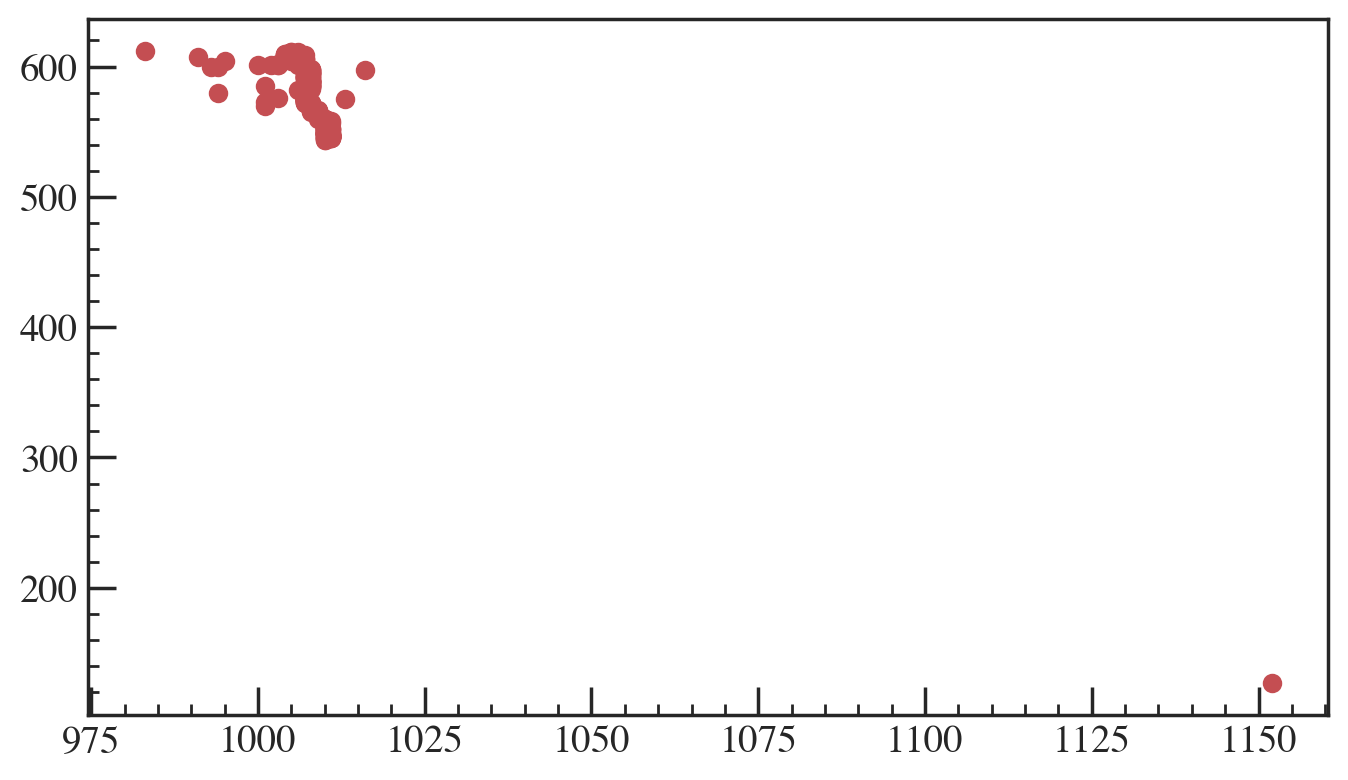

In [20]:
#TEST: plotting all centers

plt.figure()

for i in range(np.shape(centers)[0]):
    plt.scatter(centers[i, 0], centers[i, 1], color='r')

# plt.xlim(800, 1200)
# plt.ylim(400, 700)

## Making video

## Register

Register images

In [21]:
#Empty list to record how much CFP (probe) channel is shifted w.r.t. GFP (ATP is bound) channel
shifts = []

for i in range(len(im_arrayGFPPos1_bs_norm)):
    shift, error, _ = phase_cross_correlation(
        im_arrayGFPPos1_bs_norm[i][crop], im_arrayCFPPos1_bs_norm[i][crop])
    shifts.append(shift)

shifts = np.array(shifts)

## Getting plotting data

  0%|          | 0/331 [00:00<?, ?it/s]

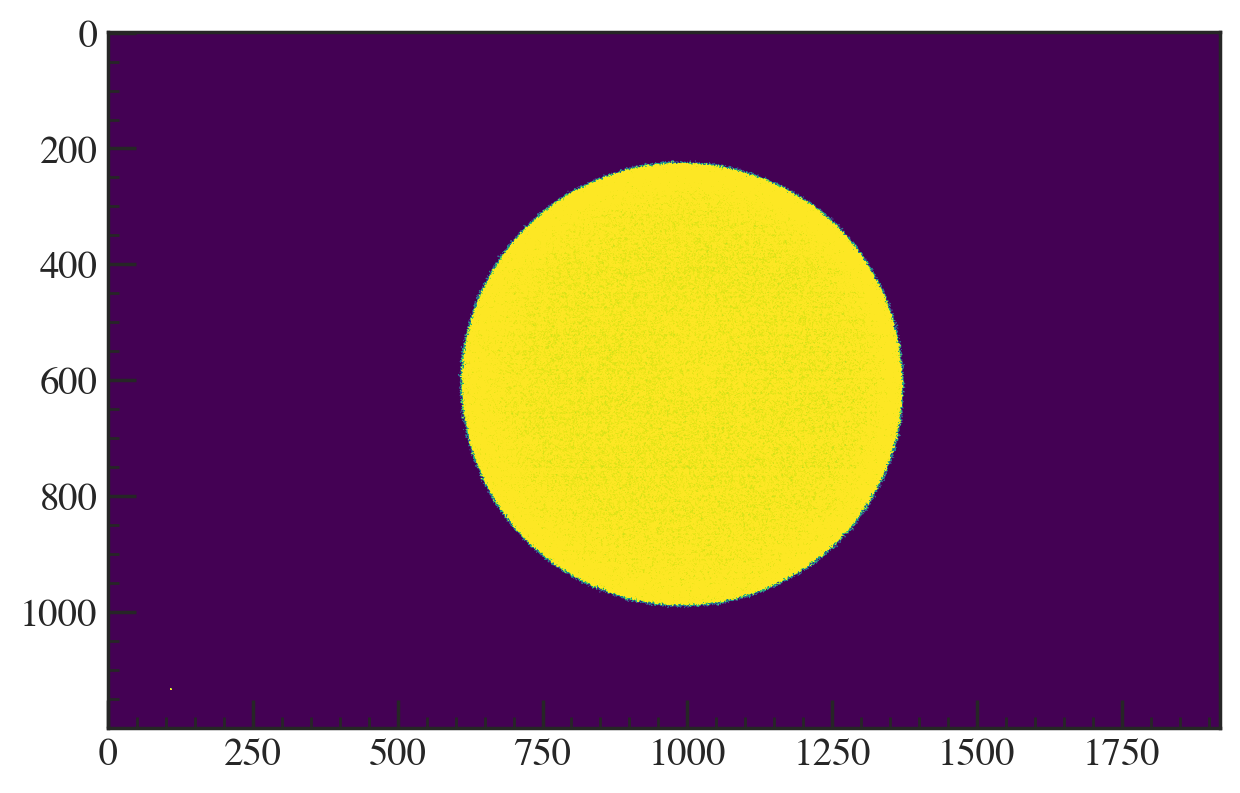

In [22]:
#cropped aster images
im_arrayGFPPos1_plot = []
im_arrayCFPPos1_plot = []
im_arrayCherryPos1_plot = []

ratios_plot = []

#Traces for asters
GFP_trace_pts = []
CFP_trace_pts = []
Cherry_trace_pts = []

ratios_trace_pts = []

for i in tqdm(frame_num):
    i_min = int(centers[i][0] - winsize)
    i_max = int(centers[i][0] + winsize)
    j_min = int(centers[i][1] - winsize)
    j_max = int(centers[i][1] + winsize)

    #demi-variable for shift
#     shift_j = int(shifts[i][0])
#     shift_i = int(shifts[i][1])

    shift_j = 0
    shift_i = 0
    
    #set GFP and CFP windows
    winGFP = np.s_[j_min:j_max, i_min:i_max]
    winCFP = np.s_[(j_min - shift_j):(j_max - shift_j),
                   (i_min - shift_i):(i_max - shift_i)]
    winCherry = np.s_[j_min:j_max, i_min:i_max]
    im_temp = im_arrayGFPPos1_bs_norm[i]
    plt.imshow(im_temp, vmin=0, vmax=np.percentile(im_temp, 90))
    
    #Append the plotting images
    [h, w] = np.shape(im_arrayGFPPos1_bs_norm[i])
    
    im_arrayGFPPos1_plot.append(im_arrayGFPPos1_bs_norm[i][winGFP])
    im_arrayCFPPos1_plot.append(im_arrayCFPPos1_bs_norm[i][winCFP])
    im_arrayCherryPos1_plot.append(im_arrayCherryPos1_bs_norm_bleach[i][winCherry]) #CHANGED TO BLEACH HERE
    #for now MT same as CFP shifts, running the shift cell seems closest to CFP

    ratio = im_arrayGFPPos1_bs_norm[i][winGFP] / im_arrayCFPPos1_bs_norm[i][winCFP]
    ratios_plot.append(ratio)

im_arrayGFPPos1_plot = np.array(im_arrayGFPPos1_plot)
im_arrayCFPPos1_plot = np.array(im_arrayCFPPos1_plot)
ratios_plot = np.array(ratios_plot)

pos_xaxis = np.linspace(-winsize, winsize, 2 * winsize)

### Plotting analysis

## Radial trace

### Parameters

In [23]:
r_inner_um = radii[100]/2
r_outer_um = r_inner_um * 2
vmax_default = 99.9

W_half = int(0.5 * w)

### Helper fxns

In [24]:
def profile_fn(im,
               r_min=2.5,
               dr=1.5,
               r_max=None,
               avg_method='median',
               n_positions=100,
               n_wedge=16):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """

    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)

    # Dimensions of the image
    H, W = im.shape

    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5 * W - 0.5
    y_center = 0.5 * H - 0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)
    angle_mat = np.mod(np.arctan2(y_mat - y_center, x_mat - x_center),
                       2 * np.pi)

    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    angle_ls = angle_mat.flatten()

    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
#     if type(r_max) != np.ndarray:
#         r_max = 0.5 * np.min([H, W]) - 0.5

    r_unif_ls = np.linspace(r_min, r_max, n_positions)

    # List of bin angles
    angle_bins = np.radians(np.linspace(0, 360, n_wedge + 1))
    angles = 0.5 * (angle_bins[1:] + angle_bins[0:-1])

    # Matrix to store average profiles in each radial bin
    avg_bin_mat = [[] for _ in range(n_wedge)]

    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
        angle_disk = angle_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]

        for k in range(n_wedge):
            dat_bin = dat[(angle_disk > angle_bins[k])
                          & (angle_disk <= angle_bins[k + 1])]

            if avg_method == 'median':
                avg_dat_bin = np.median(dat_bin)
            elif avg_method == 'mean':
                avg_dat_bin = np.mean(dat_bin)
            avg_bin_mat[k].append(avg_dat_bin)

    avg_bin_mat = np.array(avg_bin_mat)
    if avg_method == 'median':
        avg_ls = np.median(avg_bin_mat, axis=0)
    elif avg_method == 'mean':
        avg_ls = np.mean(avg_bin_mat, axis=0)
    else:
        raise ValueError('Incorrect averaging method specified.')

    std_ls = np.std(avg_bin_mat, axis=0)

    # Keep only the points inside the disk
    im_ls = im_ls[r_ls <= r_max]
    r_ls = r_ls[r_ls <= r_max]

    profile_output = {
        "r_unif_ls": r_unif_ls,
        "r_unif_ls_um": r_unif_ls * um_per_pixel,
        "avg_ls": avg_ls,
        "std_ls": std_ls,
        "avg_bin_mat": avg_bin_mat,
        "angles": angles,
        "r_ls": r_ls,
        "im_ls": im_ls
    }

    return profile_output

### Wedge plot

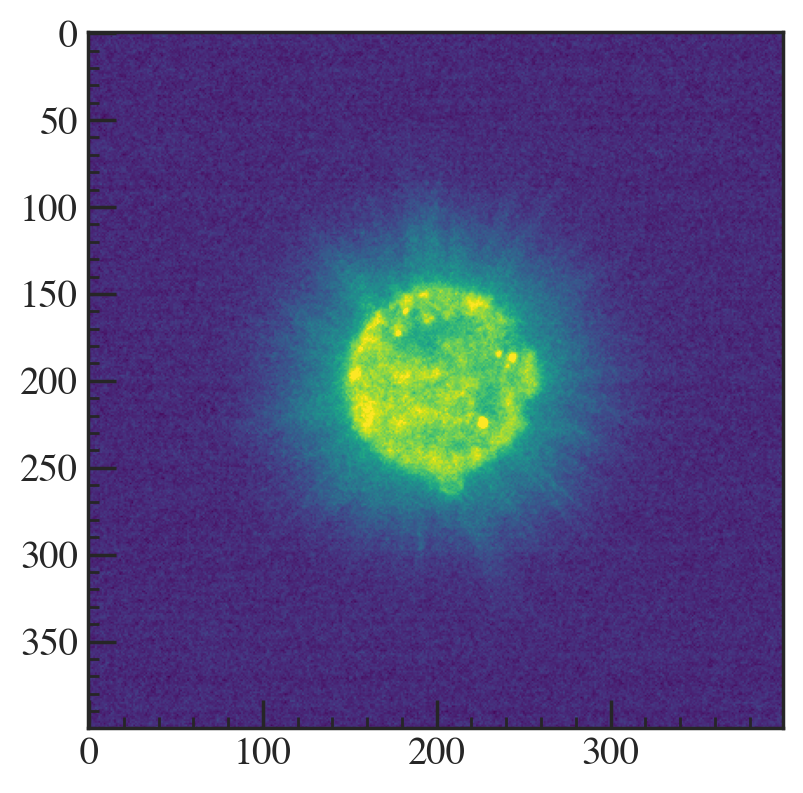

In [25]:
center = centers[100]
im = im_arrayCherryPos1_bs_norm[100][(int(center[1])-winsize): (int(center[1]) + winsize), 
                               (int(center[0])-winsize):(int(center[0])+winsize)]


plt.imshow(im, vmin = np.percentile(im, 0), vmax = np.percentile(im, vmax_default))

In [26]:
np.shape(ratios_plot)

(331, 400, 400)

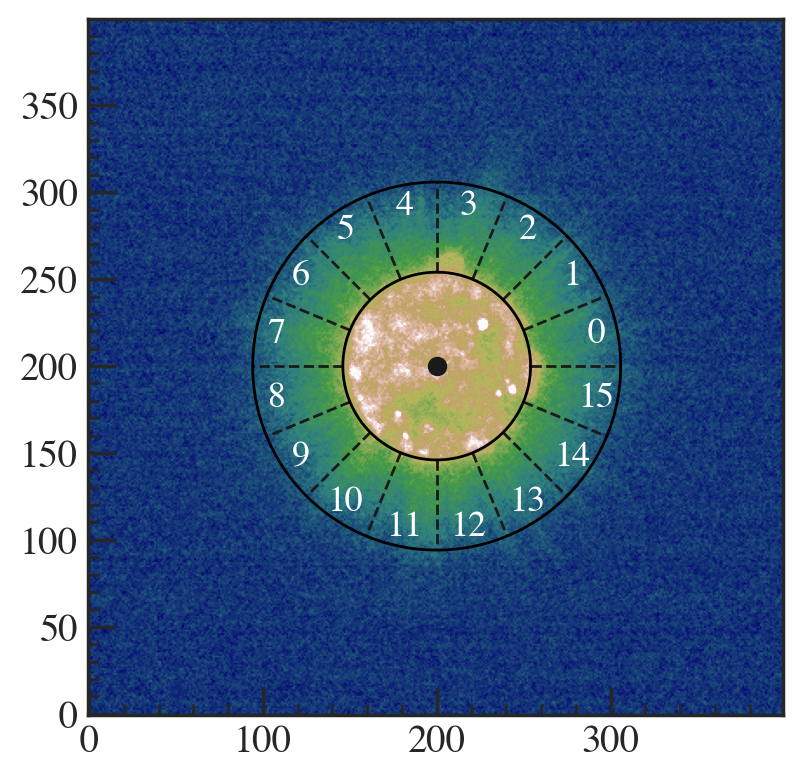

In [33]:
#######################################################################
# --------------- Show aster with boundaries & wedges --------------- #
#######################################################################

center = centers[100]
im = im_arrayCherryPos1_bs_norm[100][int(center[1])-winsize : int(center[1]) + winsize, 
                               int(center[0])-winsize:int(center[0])+winsize]
plt.imshow(im, 
           origin='lower', 
#            extent = (-r_outer_um, r_outer_um, -r_outer_um, r_outer_um),
           vmin = np.percentile(im, 0), vmax = np.percentile(im, vmax_default),
           cmap = "gist_earth")

n_wedge = 16
angle_bins = np.radians(np.linspace(0,360,n_wedge+1))
angles = 0.5*(angle_bins[1:] + angle_bins[0:-1])

for i in range(len(angle_bins)-1):
    angle = angle_bins[i]
    xx = [r_inner_um*np.cos(angle), 0.98*r_outer_um*np.cos(angle)]
    yy = [r_inner_um*np.sin(angle), 0.98*r_outer_um*np.sin(angle)]
    
    xx = np.array(xx)
    yy = np.array(yy)
    
    xx += winsize
    yy += winsize
    
    plt.plot(xx, yy, '--', color='k', alpha=1, linewidth=1)

    dangle = angle_bins[1]-angle_bins[0]
    x_text = 0.87*r_outer_um*np.cos(angle+0.5*dangle) + winsize
    y_text = 0.87*r_outer_um*np.sin(angle+0.5*dangle) + winsize
    plt.text(x_text, y_text, str(i), color='w', alpha=1,
             horizontalalignment='center', verticalalignment='center')

thetas = np.linspace(0,2*np.pi,200)

x_circ_inner = r_inner_um*np.cos(thetas) + winsize
y_circ_inner = r_inner_um*np.sin(thetas) + winsize
plt.plot(x_circ_inner, y_circ_inner, color='black', alpha=1, linewidth = 1)

x_circ_outer = 0.98*r_outer_um*np.cos(thetas) + winsize
y_circ_outer = 0.98*r_outer_um*np.sin(thetas) + winsize
plt.plot(x_circ_outer, y_circ_outer, color='black', alpha=1, linewidth = 1)
plt.scatter(winsize,winsize, color="k")

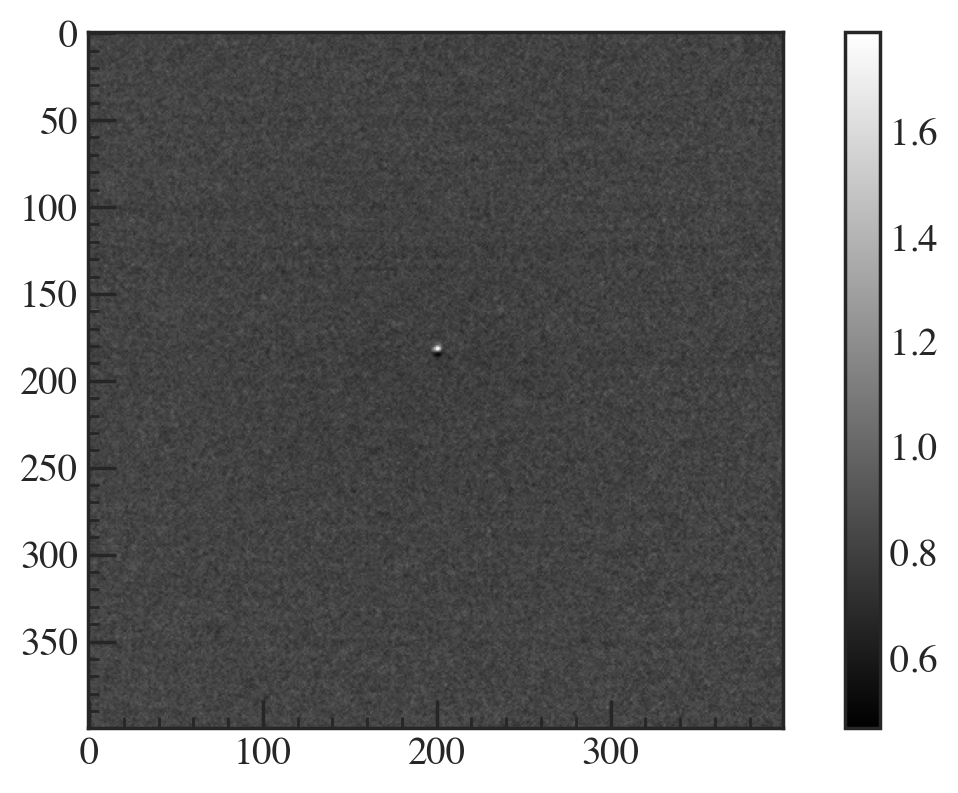

In [28]:
im_test = ratios_plot[80]
plt.imshow(im_test, vmin= np.min(im_test), vmax = np.percentile(im_test, 100), cmap = 'gist_gray')
plt.colorbar()

### Generating profiles

In [28]:
r_inner_um = radii[100]/3
r_outer_um = 203
vmax_default = 99.9

W_half = int(0.5 * w)

In [92]:
# getting GFP, CFP, MT, Cherry profiles averaged across radial blochs

output_GFP = []
output_CFP = []
output_Cherry = []
output_ratios = []

num_pos = 100

avg_method_default = 'mean'

#                           r_min=radii[i],
#                           r_max=100,

for i, frame in tqdm(enumerate(frame_num)):

    prof_GFP = profile_fn(im_arrayGFPPos1_plot[i],
                          r_min=r_outer_um,
                          r_max=r_inner_um,
                          avg_method=avg_method_default,
                          n_positions=num_pos)
    prof_CFP = profile_fn(im_arrayCFPPos1_plot[i],
                          r_min=r_outer_um,
                          r_max=r_inner_um,
                          avg_method=avg_method_default,
                          n_positions=num_pos)
    prof_Cherry = profile_fn(im_arrayCherryPos1_plot[i],
                          r_min=r_outer_um,
                          r_max=r_inner_um,
                         avg_method=avg_method_default,
                         n_positions=num_pos)
    prof_ratios = profile_fn(ratios_plot[i],
                          r_min=r_outer_um,
                          r_max=r_inner_um,
                             avg_method=avg_method_default,
                             n_positions=num_pos)

    output_GFP.append(prof_GFP)
    output_CFP.append(prof_CFP)
    output_Cherry.append(prof_Cherry)
    output_ratios.append(prof_ratios)

0it [00:00, ?it/s]

### Convert to concentration units

ATP:

In [93]:
def ATP_inten_to_conc(array, a, b, c, d):
    return a * ((c - array) / (array - b)) ** (1/d)

In [94]:
output_ratios_conc_units = []

for i, num in enumerate(frame_num):
    ratio_conc = ATP_inten_to_conc(output_ratios[i]['avg_ls'], 629, 1.44, 0.79, 2.1)
    output_ratios_conc_units.append(ratio_conc)
    
output_ratios_conc_units = np.array(output_ratios_conc_units)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_6978/1203200823.py:2: RuntimeWarning: invalid value encountered in power
  return a * ((c - array) / (array - b)) ** (1/d)


Motor:

In [95]:
def calibrate_motor(im, norm_mat, offset_camera, auto_fluo, protein_per_fluo):
    """
    Calibrate a fluorescence image using the normalization matrix and
    the intensity calibration factor.
    
    Parameters
    ----------
    im : numpy array
        Image to be calibrated.
    
    norm_mat : numpy array
        Normalization matrix.
        
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    auto_fluo : float
        Autofluorescence (coming from the energy mix).
        
    protein_per_fluo : float
        Calibration factor for converting fluorescence units
        into protein concentration units.
        
    Returns
    -------
    im : numpy array
        Calibrated image.
    """
    
    im = im.astype(float)
    im = skimage.filters.median(im)
    im = im - offset_camera
    im = im * norm_mat
    im = im - auto_fluo;
    im = im * protein_per_fluo
    return im

In [96]:
def calibrate_motor(output_Cherry, protein_per_fluo):
    """
    Calibrate a fluorescence image using the normalization matrix and
    the intensity calibration factor.
    
    Parameters
    ----------
    im : numpy array
        Image to be calibrated.
    
    norm_mat : numpy array
        Normalization matrix.
        
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    auto_fluo : float
        Autofluorescence (coming from the energy mix).
        
    protein_per_fluo : float
        Calibration factor for converting fluorescence units
        into protein concentration units.
        
    Returns
    -------
    im : numpy array
        Calibrated image.
    """
    
    output_Cherry = output_Cherry * protein_per_fluo
    return output_Cherry

In [97]:
output_Cherry_conc_units = []

for i, num in enumerate(frame_num):
    Cherry_conc = calibrate_motor(output_Cherry[i]['avg_ls'], protein_per_fluo)
    output_Cherry_conc_units.append(Cherry_conc)
    
output_Cherry_conc_units = np.array(output_Cherry_conc_units)

In [98]:
print(output_Cherry_conc_units)

[[0.98093393 0.98315906 0.98109038 ... 0.98719    0.98626874 0.99015683]
 [0.98565037 0.98066072 0.98349476 ... 1.01546772 1.01695122 1.01368942]
 [0.98870416 0.9927771  0.98908571 ... 1.00083367 1.00289525 1.00150044]
 ...
 [1.23587081 1.24410152 1.25499734 ... 2.41931552 2.45590958 2.48765781]
 [1.23037669 1.24069101 1.24508764 ... 2.41581928 2.44061091 2.47655795]
 [1.24432813 1.25178242 1.25455357 ... 2.41734549 2.45127034 2.49027011]]


In [99]:
#Define the frames to plot
plot_frames = frame_num
plot_times = frame_num * 20 / 60  #min
color_background = '#E5E0D5'

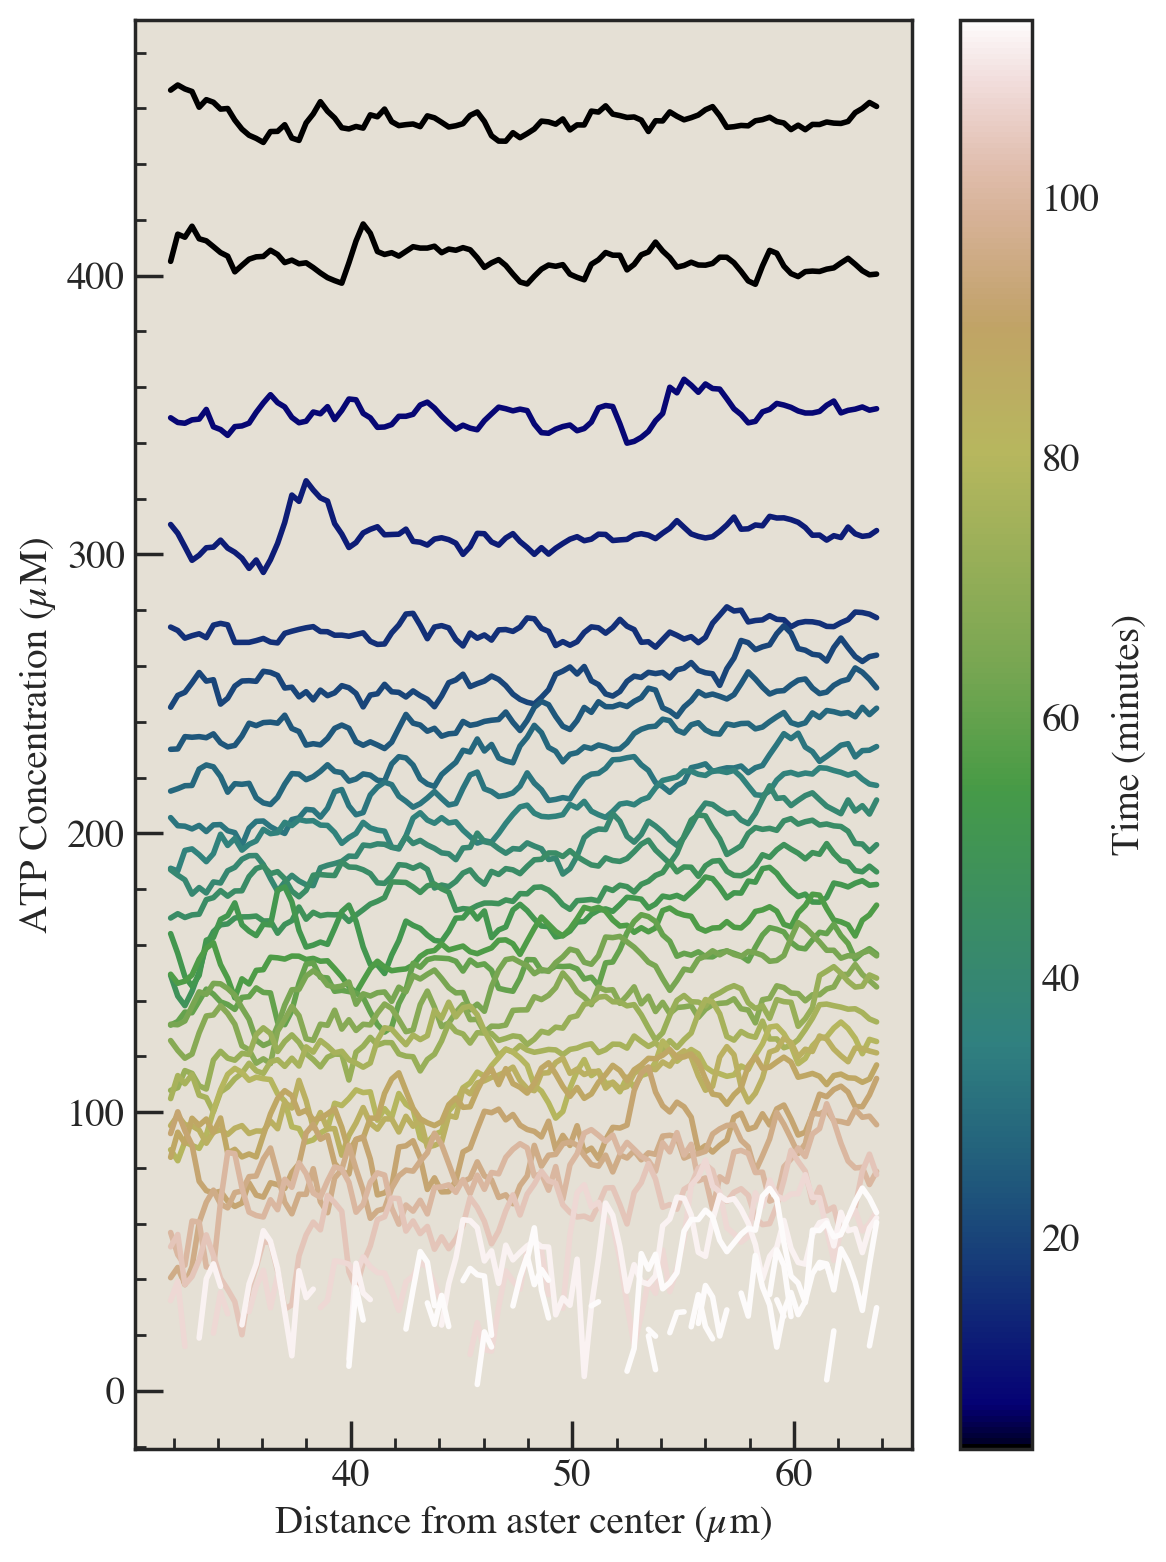

In [100]:
mod_num = 4

fig, ax = plt.subplots(figsize=(6, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_times.min(), vmax=plot_times.max())
colormap = cm.gist_earth

for i, frame in enumerate(plot_frames):
    if i%mod_num == 0:
        ax.plot(output_ratios[i]['r_unif_ls_um'],
                 output_ratios_conc_units[i],
                 lw=2,
                 color = colormap(normalize(i)),
                 label=str(round(plot_times[i], 2)))

plt.xlabel('Distance from aster center (µm)')
plt.ylabel('ATP Concentration (µM)')
ax.set_facecolor(color_background)

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(plot_times)
cbar = plt.colorbar(scalarmappaple, label = "Time (minutes)")
#cbar.set_label('Time (s)', rotation=270)
plt.tight_layout()

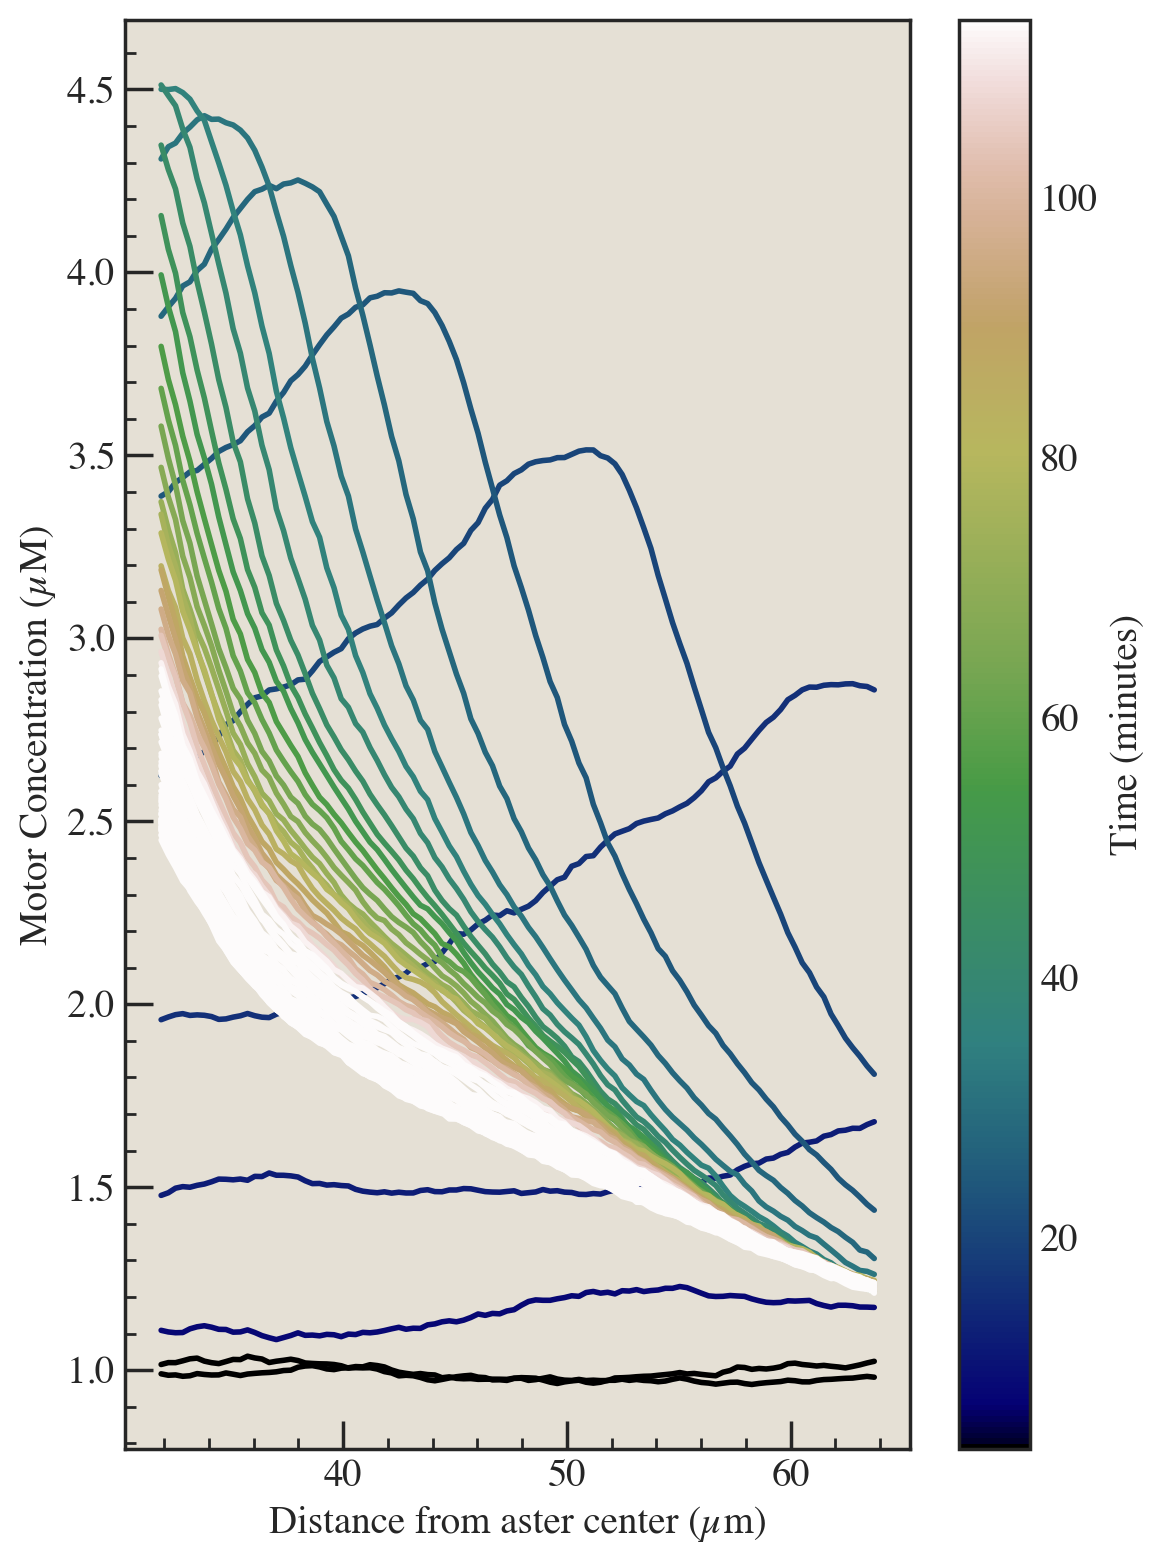

In [101]:
mod_num = 4

fig, ax = plt.subplots(figsize=(6, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_times.min(), vmax=plot_times.max())
colormap = cm.gist_earth

for i, frame in enumerate(plot_frames):
    if i%mod_num==0:
        ax.plot(output_Cherry[i]['r_unif_ls_um'],
                 output_Cherry_conc_units[i],
                 lw=2,
                 color = colormap(normalize(i)),
                 label=str(round(plot_times[i], 2)))

plt.xlabel('Distance from aster center (µm)')
plt.ylabel('Motor Concentration (µM)')
ax.set_facecolor(color_background)

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(plot_times)
cbar = plt.colorbar(scalarmappaple, label = "Time (minutes)")

plt.tight_layout()

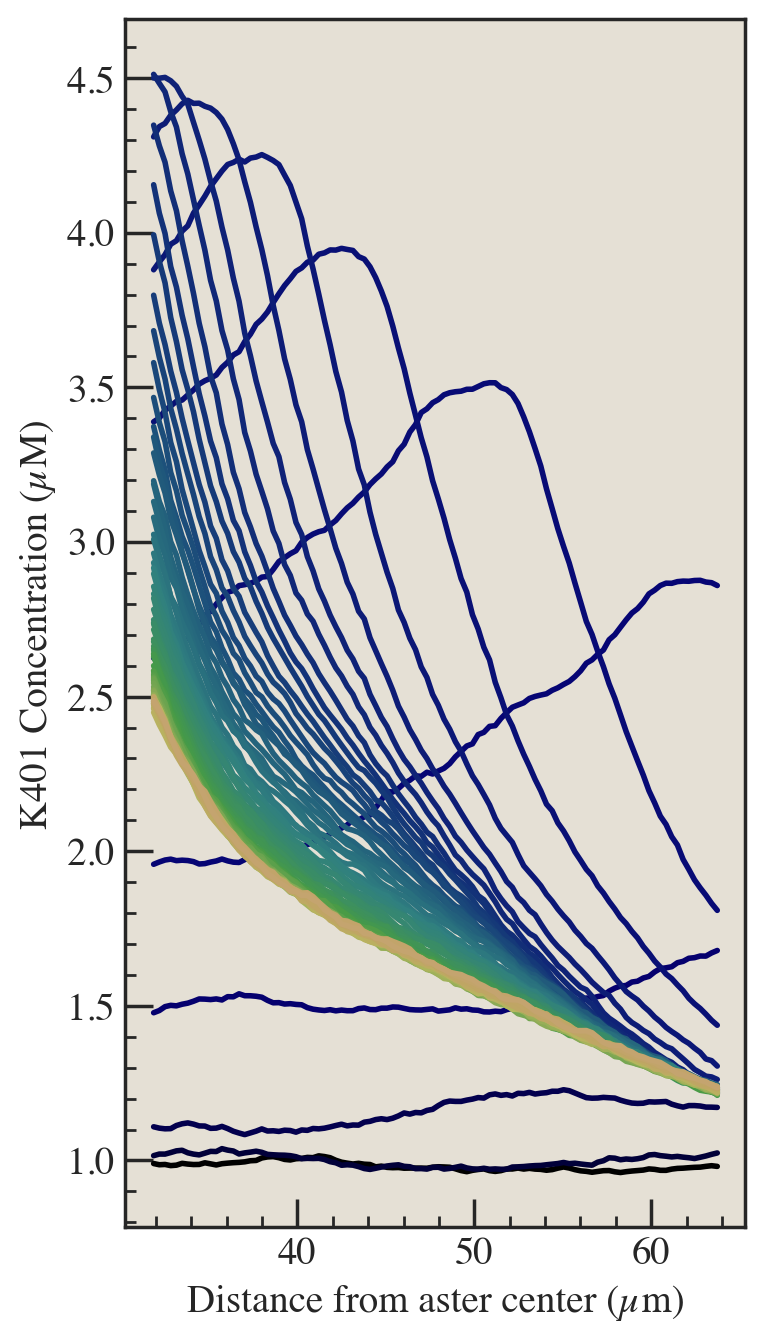

In [102]:
# fig, ax = plt.subplots(figsize=(2, 4))
# plt.gca().set_prop_cycle(
#     plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8,
#                                                       len(plot_frames)))))
# # plt.gca().set_prop_cycle(
# #     plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8,
# #                                                       len(plot_frames)))))

# for i, frame in enumerate(plot_frames):
#     ax.plot(output_Cherry[i]['r_unif_ls_um'],
#              output_Cherry_conc_units[i],
#              lw=2,
#              label=str(round(plot_times[i], 2)))
# #plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
# plt.xlabel('Distance from aster center (µm)')
# plt.ylabel('K401 (µM)')
# ax.set_facecolor(color_background)

mod_num = 4

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8,
                                                      int(len(plot_frames)/mod_num)+1))))
# plt.gca().set_prop_cycle(
#     plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8,
#                                                       len(plot_frames)))))

for i, frame in enumerate(plot_frames):
    if i%mod_num==0:
        ax.plot(output_Cherry[i]['r_unif_ls_um'],
                 output_Cherry_conc_units[i],
                 lw=2,
                 label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('K401 Concentration (µM)')
ax.set_facecolor(color_background)

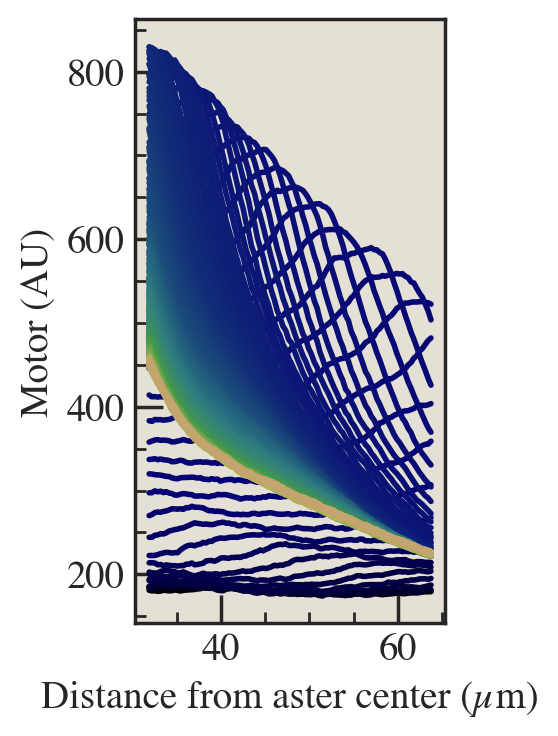

In [103]:
fig, ax = plt.subplots(figsize=(2, 4))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8,
                                                      len(plot_frames)))))
# plt.gca().set_prop_cycle(
#     plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8,
#                                                       len(plot_frames)))))

for i, frame in enumerate(plot_frames):
    ax.plot(output_Cherry[i]['r_unif_ls_um'],
             output_Cherry[i]['avg_ls'],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('Motor (AU)')
ax.set_facecolor(color_background)


  0%|          | 0/16 [00:00<?, ?it/s]

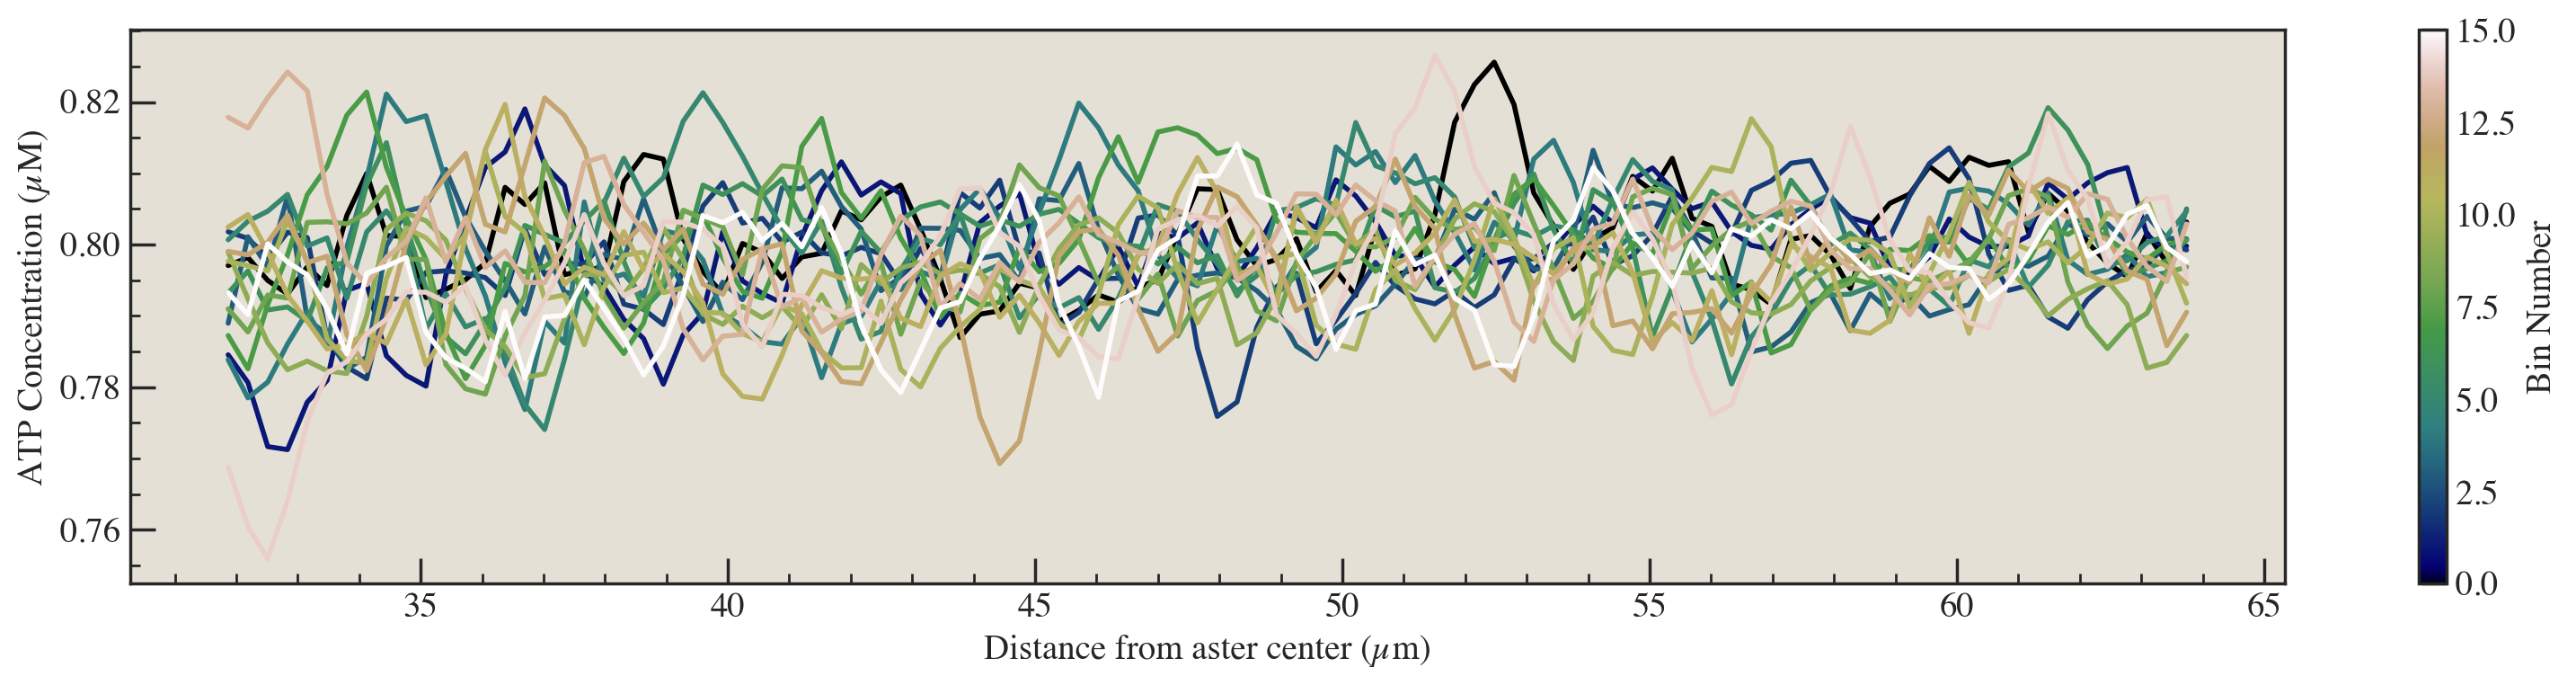

In [104]:
mod_num = 1
sector_num = np.arange(16)
im = output_ratios[100]

fig, ax = plt.subplots(figsize=(16, 4))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=sector_num.min(), vmax=sector_num.max())
colormap = cm.gist_earth

for i in tqdm(range(16)):
    ax.plot(im['r_unif_ls_um'],
             im['avg_bin_mat'][i],
             lw=2,
             color = colormap(normalize(i)),
             label=str(round(i, 2)))

plt.xlabel('Distance from aster center (µm)')
plt.ylabel('ATP Concentration (µM)')
ax.set_facecolor('#E5E0D5')

#setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(im['avg_bin_mat'][:][0])
cbar = plt.colorbar(scalarmappaple, label = "Bin Number")
#cbar.set_label('Time (s)', rotation=270)
plt.tight_layout()

## Plot Motors ###
#--- earth ---#

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8,
                                                      len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_Cherry[i]['r_unif_ls'],
             output_Cherry[i]['avg_ls'],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('Motor Intensity (A.U.)')
ax.set_facecolor(color_background)

#--- flag ---#

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_Cherry[i]['r_unif_ls'],
             output_Cherry[i]['avg_ls'],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('Motor Intensity (A.U.)')
ax.set_facecolor(color_background)


### Plot GFP ###

#--- earth ---#

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8,
                                                      len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_GFP[i]['r_unif_ls'],
             output_GFP[i]['avg_ls'],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('GFP Intensity (A.U.)')
ax.set_facecolor(color_background)

#--- flag ---#

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_GFP[i]['r_unif_ls'],
             output_GFP[i]['avg_ls'],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('GFP Intensity (A.U.)')
ax.set_facecolor(color_background)

### Plot CFP ###

#--- earth ---#

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8,
                                                      len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_CFP[i]['r_unif_ls_um'],
             output_CFP[i]['avg_ls'],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('CFP Intensity (A.U.)')
ax.set_facecolor(color_background)

#--- flag ---#

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_CFP[i]['r_unif_ls_um'],
             output_CFP[i]['avg_ls'],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('CFP Intensity (A.U.)')
ax.set_facecolor(color_background)

### Plot Ratio ###

#--- earth ---#

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8,
                                                      len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_ratios[i]['r_unif_ls_um'],
             output_ratios_conc_units[i],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('GFP/CFP (A.U.)')
ax.set_facecolor(color_background)

#--- flag ---#

fig, ax = plt.subplots(figsize=(4, 8))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))
for i, frame in enumerate(plot_frames):
    plt.plot(output_ratios[i]['r_unif_ls_um'],
             output_ratios_conc_units[i],
             lw=2,
             label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
plt.xlabel('Distance from aster center (µm)')
plt.ylabel('GFP/CFP (A.U.)')
ax.set_facecolor(color_background)


### Final radial traces

In [38]:
#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
# ax[0, 0].set_prop_cycle(
#     plt.cycler(
#         'color',
#         plt.cm.gist_earth(
#             np.linspace(0.1, 0.80, upper_bound_cycler))))
# ax[0, 1].set_prop_cycle(
#     plt.cycler(
#         'color',
#         plt.cm.gist_earth(
#             np.linspace(0.1, 0.80, upper_bound_cycler))))
# ax[0, 2].set_prop_cycle(
#     plt.cycler(
#         'color',
#         plt.cm.gist_earth(
#             np.linspace(0.1, 0.80, upper_bound_cycler))))
# ax[1, 0].set_prop_cycle(
#     plt.cycler(
#         'color',
#         plt.cm.gist_earth(
#             np.linspace(0.1, 0.80, upper_bound_cycler))))
# ax[1, 1].set_prop_cycle(
#     plt.cycler(
#         'color',
#         plt.cm.gist_earth(
#             np.linspace(0.1, 0.80, upper_bound_cycler))))
# ax[1, 2].set_prop_cycle(
#     plt.cycler(
#         'color',
#         plt.cm.gist_earth(
#             np.linspace(0.1, 0.80, upper_bound_cycler))))

IndexError: list index out of range

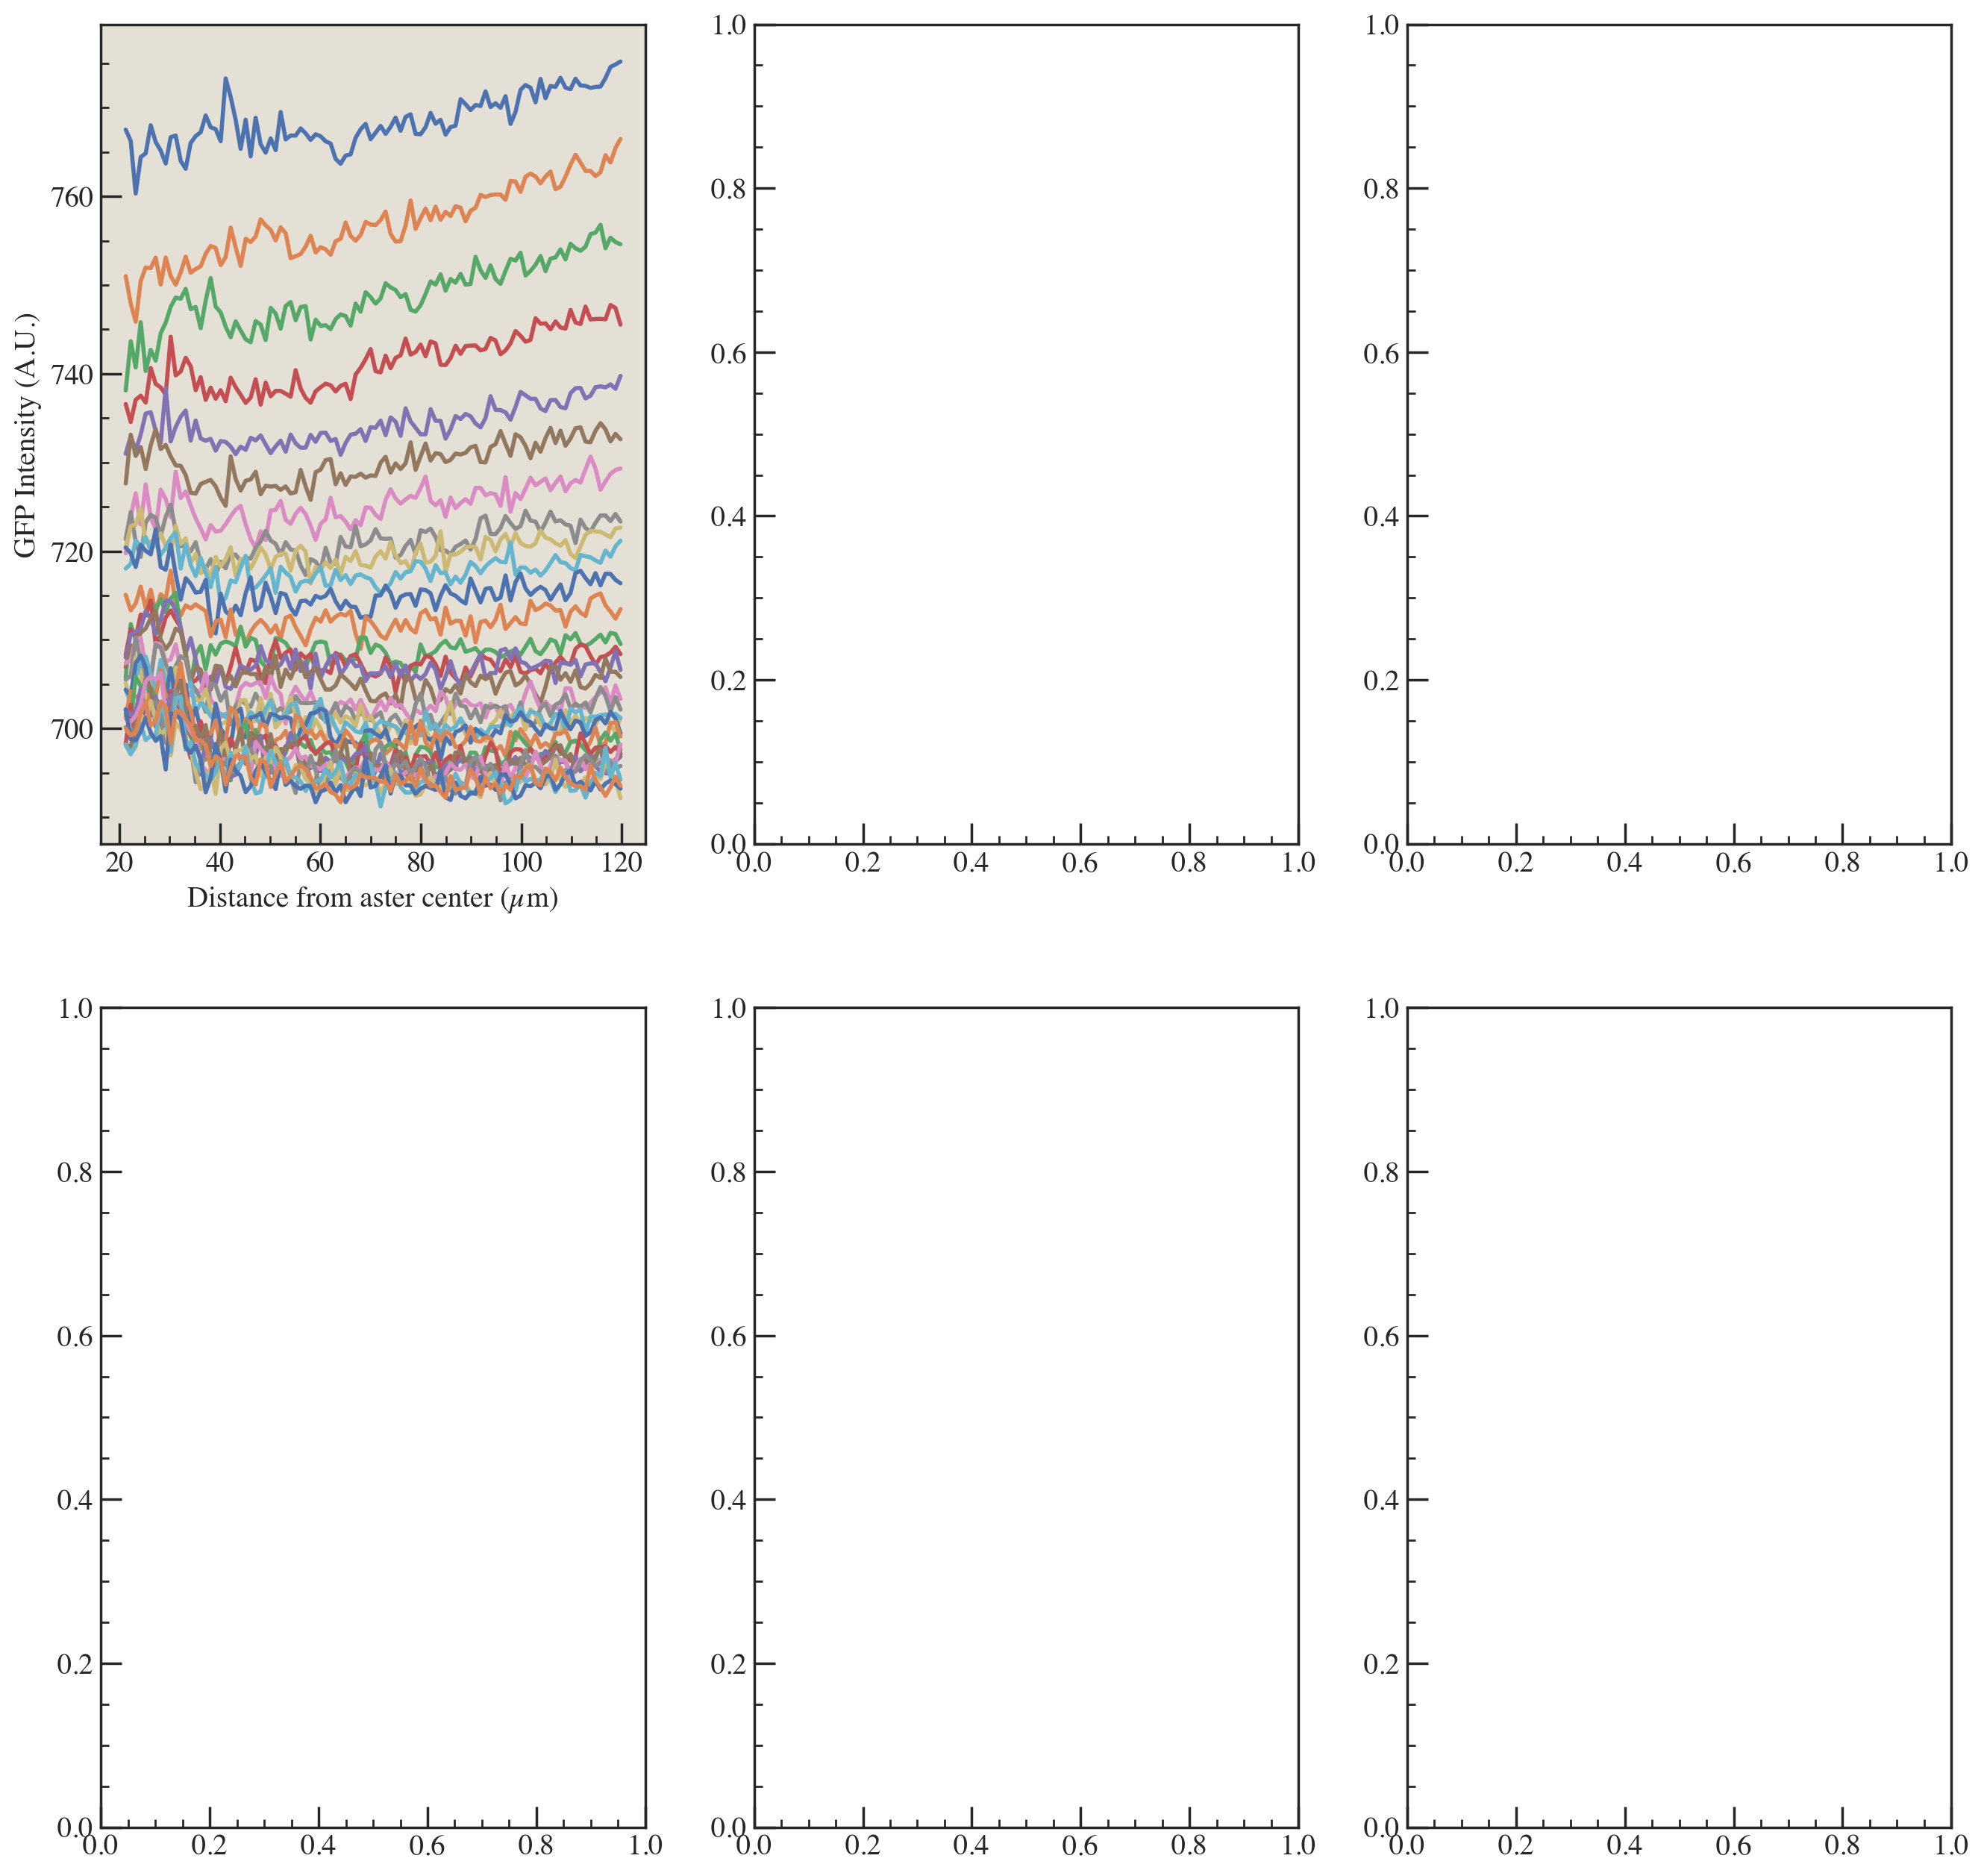

In [39]:
#Define the frames to plot
plot_frames = frame_num[:-2]
plot_times = frame_num * 20 / 60  #min
mod_num = 10

upper_bound_cycler = int(len(ratios_trace_pts) / mod_num)
                      
fig, ax = plt.subplots(2, 3, figsize=(16, 16))
plt.gca().set_prop_cycle(
    plt.cycler('color', plt.cm.flag(np.linspace(0, 0.8, len(plot_frames)))))

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[0,0].plot(output_GFP[frame]['r_unif_ls_um'], 
                     output_GFP[frame]['avg_ls'], 
                     lw=2,
                     label=str(round(plot_times[frame], 2)))
        
        #plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
        ax[0, 0].set_xlabel('Distance from aster center (µm)')
        ax[0, 0].set_ylabel('GFP Intensity (A.U.)')
        ax[0, 0].set_facecolor(color_background)

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[0, 1].plot(output_CFP[i]['r_unif_ls_um'],
                      output_CFP[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
        #plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
        ax[0, 1].set_xlabel('Distance from aster center (µm)')
        ax[0, 1].set_ylabel('CFP Intensity (A.U.)')
        ax[0, 1].set_facecolor(color_background)

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[0, 2].plot(output_ratios[i]['r_unif_ls_um'],
                      output_ratios[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
        #plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
        ax[0, 2].set_xlabel('Distance from aster center (µm)')
        ax[0, 2].set_ylabel('GFP/CFP (A.U.)')
        ax[0, 2].set_facecolor(color_background)

# ----- Flag same as above ----#
for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[1, 0].plot(output_GFP[i]['r_unif_ls_um'],
                      output_GFP[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
        #plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
        ax[1, 0].set_xlabel('Distance from aster center (µm)')
        ax[1, 0].set_ylabel('GFP Intensity (A.U.)')
        ax[1, 0].set_facecolor(color_background)

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[1, 1].plot(output_CFP[i]['r_unif_ls_um'],
                      output_CFP[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
        #plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
        ax[1, 1].set_xlabel('Distance from aster center (µm)')
        ax[1, 1].set_ylabel('CFP Intensity (A.U.)')
        ax[1, 1].set_facecolor(color_background)

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[1, 2].plot(output_ratios[i]['r_unif_ls_um'],
                      output_ratios[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
        #plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
        ax[1, 2].set_xlabel('Distance from aster center (µm)')
        ax[1, 2].set_ylabel('GFP/CFP (A.U.)')
        ax[1, 2].set_facecolor(color_background)

plt.tight_layout()

RuntimeError: generator raised StopIteration

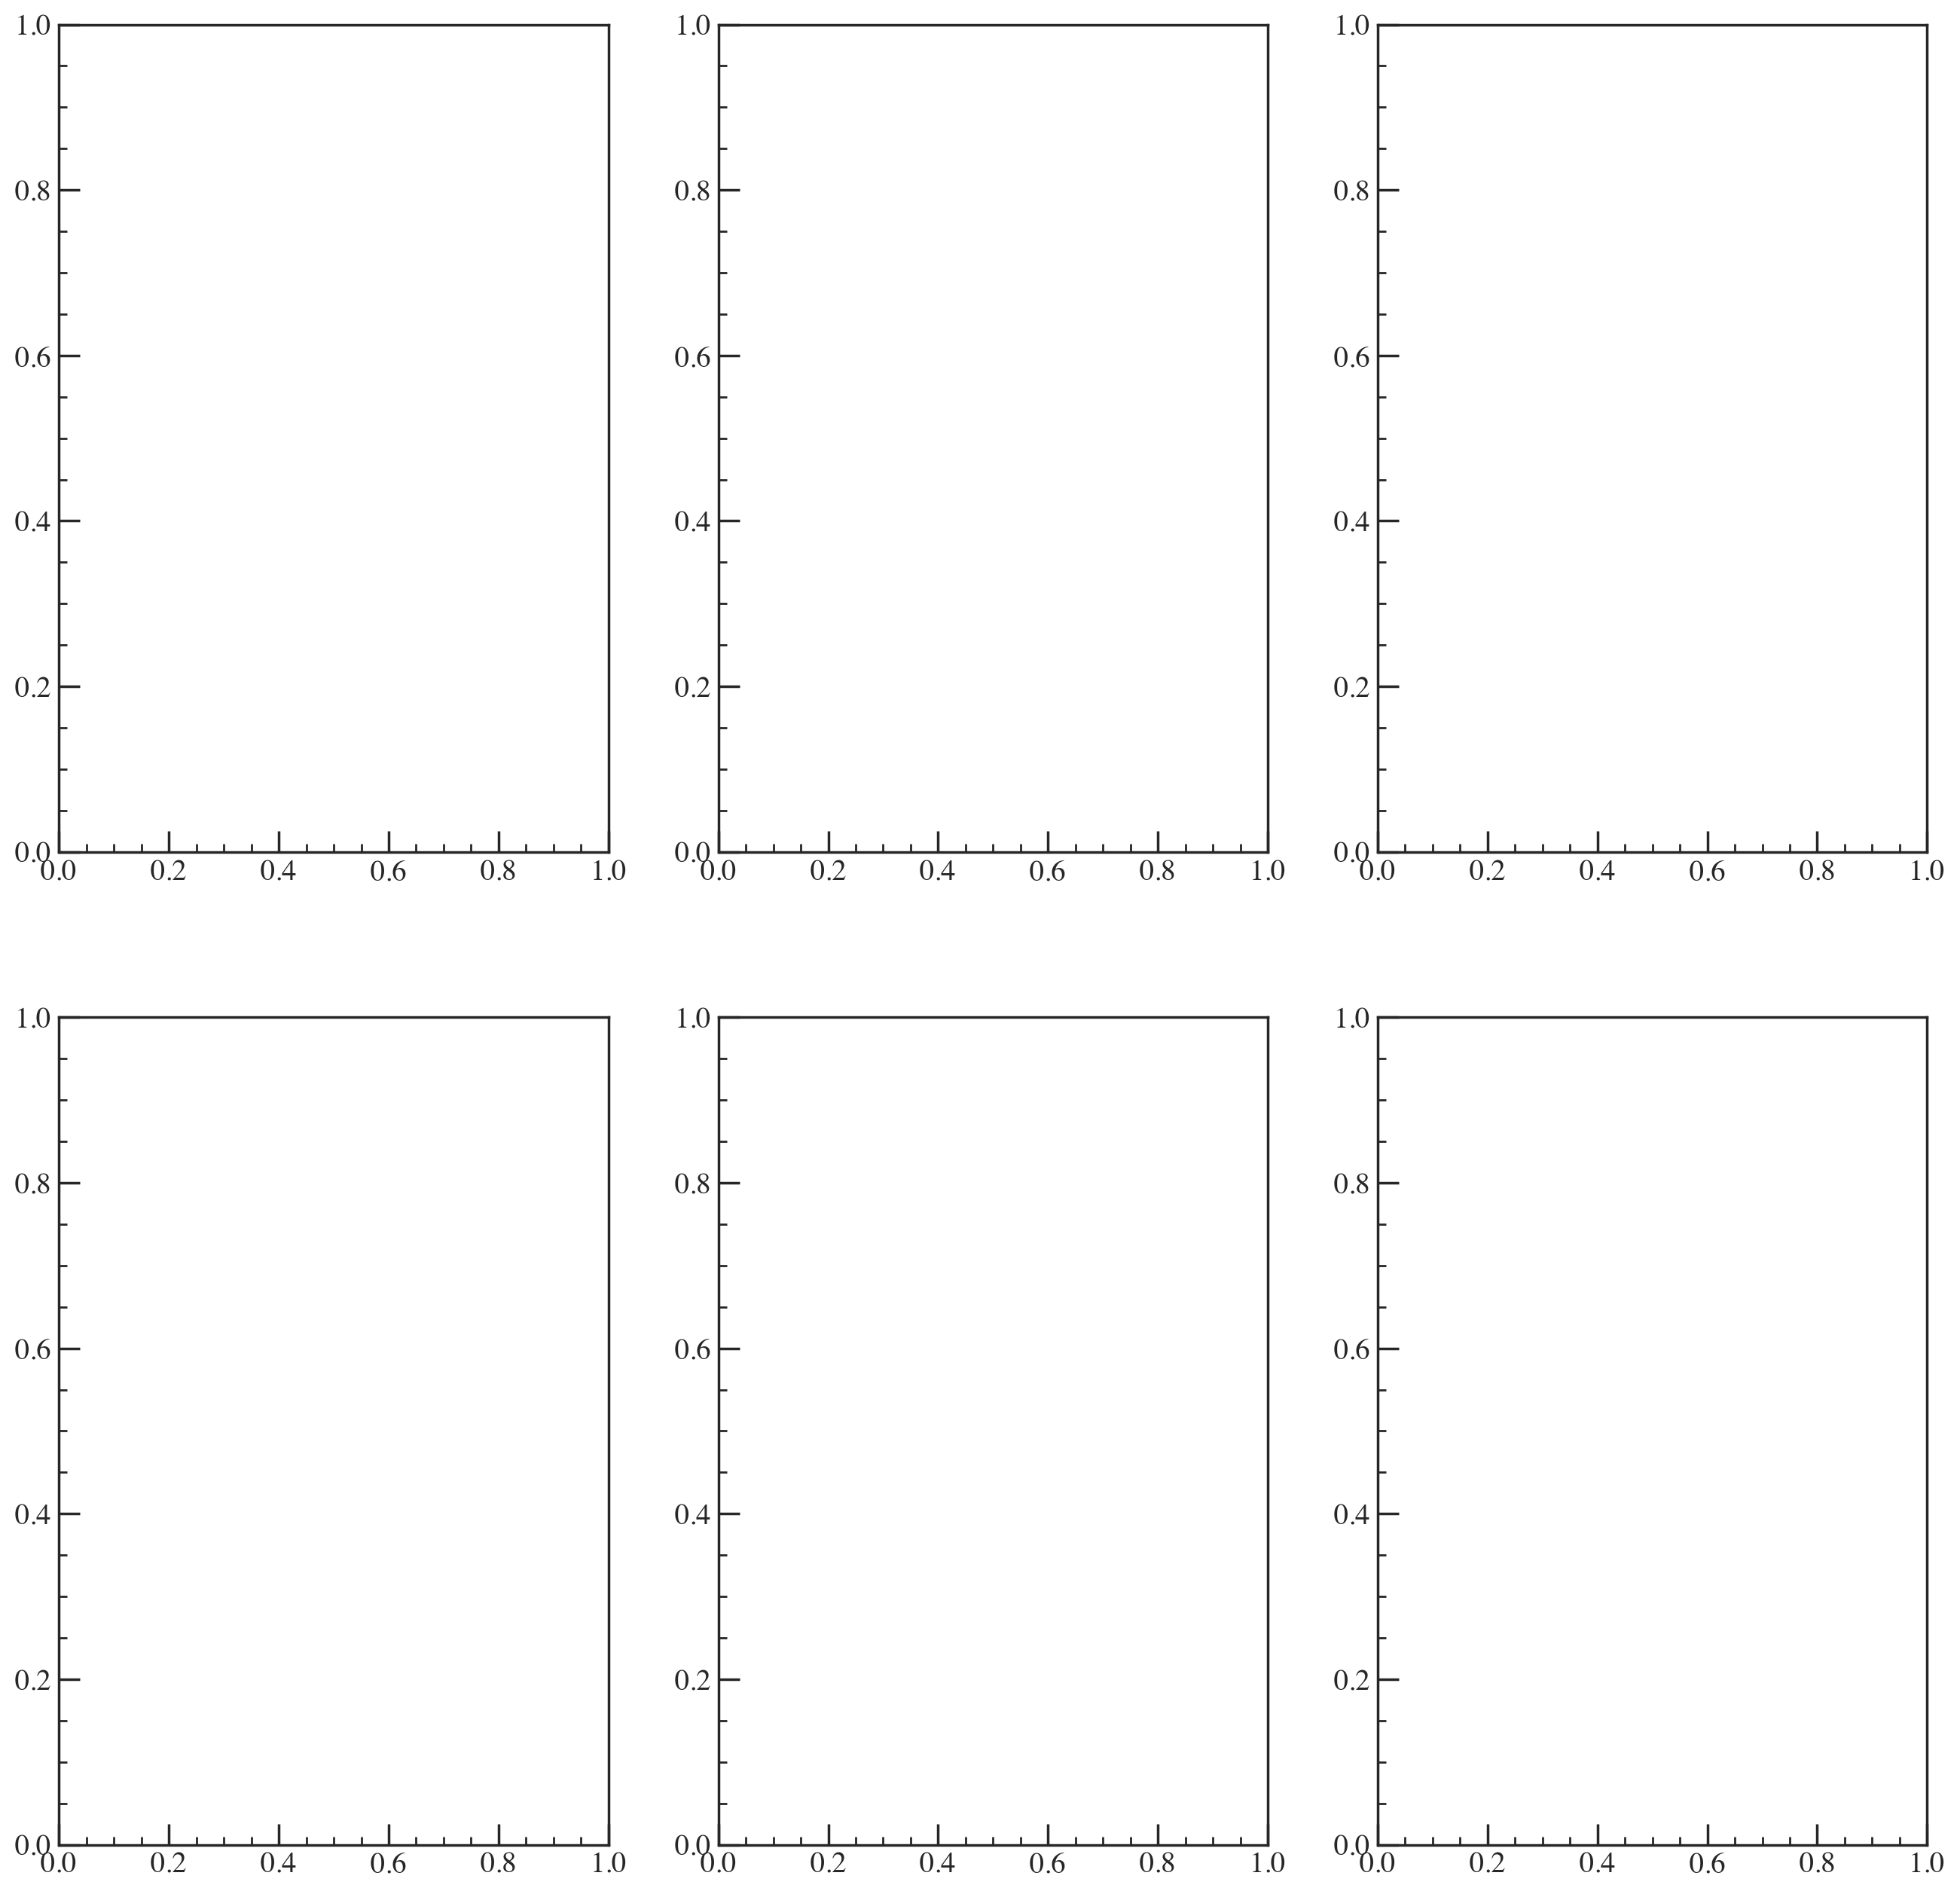

In [40]:
#Define the frames to plot
plot_frames = frame_num[:-2]
plot_times = frame_num * 20 / 60  #min

upper_bound_cycler = int(len(ratios_trace_pts) / mod_num)

fig, ax = plt.subplots(2, 3, figsize=(16, 16))
#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_earth(np.linspace(0, 0.8, len(plot_frames)))))
ax[0, 0].set_prop_cycle(
    plt.cycler(
        'color',
        plt.cm.gist_earth(
            np.linspace(0.1, 0.80, upper_bound_cycler))))
ax[0, 1].set_prop_cycle(
    plt.cycler(
        'color',
        plt.cm.gist_earth(
            np.linspace(0.1, 0.80, upper_bound_cycler))))
ax[0, 2].set_prop_cycle(
    plt.cycler(
        'color',
        plt.cm.gist_earth(
            np.linspace(0.1, 0.80, upper_bound_cycler))))
ax[1, 0].set_prop_cycle(
    plt.cycler(
        'color',
        plt.cm.gist_earth(
            np.linspace(0.1, 0.80, upper_bound_cycler))))
ax[1, 1].set_prop_cycle(
    plt.cycler(
        'color',
        plt.cm.gist_earth(
            np.linspace(0.1, 0.80, upper_bound_cycler))))
ax[1, 2].set_prop_cycle(
    plt.cycler(
        'color',
        plt.cm.gist_earth(
            np.linspace(0.1, 0.80, upper_bound_cycler))))

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[0, 0].plot(output_CFP[i]['r_unif_ls_um'],
                      output_GFP[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[0, 0].set_xlabel('Distance from aster center (µm)')
ax[0, 0].set_ylabel('GFP Intensity (A.U.)')
ax[0, 0].set_facecolor(color_background)

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[0, 1].plot(output_CFP[i]['r_unif_ls_um'],
                      output_CFP[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[0, 1].set_xlabel('Distance from aster center (µm)')
ax[0, 1].set_ylabel('CFP Intensity (A.U.)')
ax[0, 1].set_facecolor(color_background)

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[0, 2].plot(output_ratios[i]['r_unif_ls_um'],
                      output_ratios[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[0, 2].set_xlabel('Distance from aster center (µm)')
ax[0, 2].set_ylabel('GFP/CFP (A.U.)')
ax[0, 2].set_facecolor(color_background)

# ----- Flag same as above ----#
for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[1, 0].plot(output_GFP[i]['r_unif_ls_um'],
                      output_GFP[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[1, 0].set_xlabel('Distance from aster center (µm)')
ax[1, 0].set_ylabel('GFP Intensity (A.U.)')
ax[1, 0].set_facecolor(color_background)

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[1, 1].plot(output_CFP[i]['r_unif_ls_um'],
                      output_CFP[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[1, 1].set_xlabel('Distance from aster center (µm)')
ax[1, 1].set_ylabel('CFP Intensity (A.U.)')
ax[1, 1].set_facecolor(color_background)

for i, frame in enumerate(plot_frames):
    if (i % mod_num == 0):
        ax[1, 2].plot(output_ratios[i]['r_unif_ls_um'],
                      output_ratios[i]['avg_ls'],
                      lw=2,
                      label=str(round(plot_times[i], 2)))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left", title = 'Time (min)', facecolor =color_background)
ax[1, 2].set_xlabel('Distance from aster center (µm)')
ax[1, 2].set_ylabel('GFP/CFP (A.U.)')
ax[1, 2].set_facecolor(color_background)

plt.tight_layout()

In [ ]:
|
